# IAQF 2026: Cross-Currency Dynamics in Cryptocurrencies under Stablecoin Regulation

## Study Overview
- **Base Asset:** Bitcoin (BTC)
- **Quote Currencies:** USD, USDT, USDC
- **Exchanges:** Binance & Coinbase
- **Data Window:** March 1 – March 21, 2023 (UTC) — covers the SVB/USDC de-peg crisis
- **Granularity:** 1-minute candles (most granular available via public APIs)

### Trading Pairs
| Exchange | Pairs |
|----------|-------|
| Binance  | BTC/USDT, BTC/USDC |
| Coinbase | BTC-USD, BTC-USDT, BTC-USDC |

### Key Event Timeline
- **March 8:** Silvergate Bank announces voluntary liquidation
- **March 10:** Silicon Valley Bank (SVB) fails; FDIC takes over; Circle discloses $3.3B USDC reserves stuck at SVB
- **March 11-12:** USDC de-pegs, trading as low as ~$0.87; panic selling across stablecoin markets
- **March 12:** US govt announces all SVB depositors will be made whole
- **March 13:** USDC re-pegs toward $1.00; markets recover

In [58]:
# ============================================================
# Cell 1: Imports & Configuration
# ============================================================
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import datetime, timedelta, timezone
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

# Time window
START_DT = datetime(2023, 3, 1, 0, 0, 0, tzinfo=timezone.utc)
END_DT   = datetime(2023, 3, 21, 23, 59, 0, tzinfo=timezone.utc)

START_MS = int(START_DT.timestamp() * 1000)
END_MS   = int(END_DT.timestamp() * 1000)

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Study window: {START_DT.isoformat()} to {END_DT.isoformat()}")
print(f"Expected 1-min candles per pair: {21 * 24 * 60:,}")

Study window: 2023-03-01T00:00:00+00:00 to 2023-03-21T23:59:00+00:00
Expected 1-min candles per pair: 30,240


---
## 1. Data Collection

We collect **1-minute OHLCV candles** from Binance and Coinbase public REST APIs. This is the most granular candle data available without requiring authenticated websocket feeds.

In [59]:
# ============================================================
# Cell 2: Binance Data Fetcher
# ============================================================

def fetch_binance_klines(symbol: str, interval: str = '1m',
                         start_ms: int = START_MS, end_ms: int = END_MS,
                         limit: int = 1000) -> pd.DataFrame:
    """
    Fetch historical klines (candlestick) data from Binance.
    Paginates automatically in chunks of `limit` candles.

    Note: Binance.com returns HTTP 451 from restricted locations (e.g., US).
    In that case we automatically fall back to Binance US.
    """
    primary_url = 'https://api.binance.com/api/v3/klines'
    fallback_url = 'https://api.binance.us/api/v3/klines'
    url = primary_url
    used_fallback = False

    all_data = []
    current_start = start_ms

    while current_start < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ms,
            'limit': limit
        }
        resp = requests.get(url, params=params, timeout=30)

        if resp.status_code == 451 and not used_fallback:
            print("  Binance.com blocked (451). Switching to binance.us for data.")
            url = fallback_url
            used_fallback = True
            continue
        if resp.status_code == 429:
            print(f"  Rate limited on {symbol}, sleeping 60s...")
            time.sleep(60)
            continue

        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        all_data.extend(data)
        # Next start = close_time of last candle + 1ms
        current_start = data[-1][6] + 1
        time.sleep(0.15)  # respect rate limits

    if not all_data:
        print(f"  WARNING: No data returned for Binance {symbol}")
        return pd.DataFrame()

    df = pd.DataFrame(all_data, columns=[
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    for col in ['open', 'high', 'low', 'close', 'volume', 'quote_volume']:
        df[col] = df[col].astype(float)
    df['trades'] = df['trades'].astype(int)
    df = df.set_index('timestamp')
    df = df[~df.index.duplicated(keep='first')]
    return df

print("Binance fetcher ready.")


Binance fetcher ready.


In [60]:
# ============================================================
# Cell 3: Coinbase Data Fetcher
# ============================================================

def fetch_coinbase_candles(product_id: str, granularity: int = 60,
                           start_dt: datetime = START_DT,
                           end_dt: datetime = END_DT) -> pd.DataFrame:
    """
    Fetch historical candles from Coinbase Advanced Trade Market Data API.
    Max ~350 candles per request; paginates automatically.
    granularity is in seconds (60 = 1 minute).
    """
    url = f'https://api.coinbase.com/api/v3/brokerage/market/products/{product_id}/candles'

    gran_map = {
        60: 'ONE_MINUTE',
        300: 'FIVE_MINUTE',
        900: 'FIFTEEN_MINUTE',
        3600: 'ONE_HOUR',
        21600: 'SIX_HOUR',
        86400: 'ONE_DAY',
    }
    if granularity not in gran_map:
        raise ValueError("Unsupported granularity. Use 60, 300, 900, 3600, 21600, or 86400 seconds.")
    granularity_str = gran_map[granularity]

    all_data = []
    # Coinbase limit: < 350 candles per request. Use 300 to be safe.
    chunk_seconds = 300 * granularity
    current_start = start_dt

    while current_start < end_dt:
        current_end = min(current_start + timedelta(seconds=chunk_seconds), end_dt)
        params = {
            'granularity': granularity_str,
            'start': int(current_start.timestamp()),
            'end': int(current_end.timestamp())
        }
        resp = requests.get(url, params=params, timeout=30)
        if resp.status_code == 429:
            print(f"  Rate limited on {product_id}, sleeping 5s...")
            time.sleep(5)
            continue
        if resp.status_code == 404:
            print(f"  WARNING: Product {product_id} not found on Coinbase Advanced Trade")
            return pd.DataFrame()
        resp.raise_for_status()
        data = resp.json().get('candles', [])
        if data:
            all_data.extend(data)
        current_start = current_end
        time.sleep(0.2)  # respect rate limits

    if not all_data:
        print(f"  WARNING: No data returned for Coinbase {product_id}")
        return pd.DataFrame()

    # Coinbase returns: start, low, high, open, close, volume (as strings)
    df = pd.DataFrame(all_data)
    if df.empty:
        return df

    df['timestamp'] = pd.to_datetime(df['start'].astype(int), unit='s', utc=True)
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)

    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]
    return df

print("Coinbase fetcher ready.")


Coinbase fetcher ready.


In [61]:
# ============================================================
# Cell 4: CryptoCompare fetcher for stablecoin peg prices
# ============================================================

def fetch_cryptocompare_ohlc(
    fsym: str,
    tsym: str = 'USD',
    start_dt: datetime = START_DT,
    end_dt: datetime = END_DT,
    timeframe: str = 'minute',
    limit: int = 2000,
    api_key = None,
    resample_to_minute: bool = True,
    allow_fallback: bool = True,
) -> pd.DataFrame:
    """
    Fetch OHLCV from CryptoCompare (aggregate across exchanges).

    timeframe: 'minute', 'hour', or 'day'

    Note: CryptoCompare only stores minute data for the last 7 days.
    For older ranges, use hourly/daily data or a paid plan.
    """
    tf = timeframe.lower()
    if tf not in {'minute', 'hour', 'day'}:
        raise ValueError("timeframe must be 'minute', 'hour', or 'day'")

    # CryptoCompare keeps minute data for only ~7 days.
    now = datetime.now(timezone.utc)
    if tf == 'minute' and end_dt < (now - timedelta(days=7)):
        if allow_fallback:
            print("  CryptoCompare minute data only available for last 7 days. Falling back to hourly data.")
            tf = 'hour'
        else:
            print("  WARNING: CryptoCompare minute data only available for last 7 days.")
            return pd.DataFrame()

    endpoint = {
        'minute': 'histominute',
        'hour': 'histohour',
        'day': 'histoday',
    }[tf]
    url = f'https://min-api.cryptocompare.com/data/v2/{endpoint}'

    api_key = api_key or os.getenv('CRYPTOCOMPARE_API_KEY')

    all_data = []
    current_end_ts = int(end_dt.timestamp())
    start_ts = int(start_dt.timestamp())

    while current_end_ts > start_ts:
        params = {
            'fsym': fsym,
            'tsym': tsym,
            'limit': limit,
            'toTs': current_end_ts,
        }
        if api_key:
            params['api_key'] = api_key

        resp = requests.get(url, params=params, timeout=30)
        resp.raise_for_status()
        result = resp.json()

        if result.get('Response') != 'Success' or not result.get('Data', {}).get('Data'):
            msg = result.get('Message', '').strip()
            if tf == 'minute' and 'last 7 days' in msg and allow_fallback:
                print("  CryptoCompare minute data only available for last 7 days. Falling back to hourly data.")
                return fetch_cryptocompare_ohlc(
                    fsym, tsym,
                    start_dt=start_dt,
                    end_dt=end_dt,
                    timeframe='hour',
                    limit=limit,
                    api_key=api_key,
                    resample_to_minute=resample_to_minute,
                    allow_fallback=False,
                )
            print(f"  WARNING: CryptoCompare returned no data for {fsym}/{tsym}. {msg}")
            break

        data = result['Data']['Data']
        all_data.extend(data)
        current_end_ts = data[0]['time'] - 1
        time.sleep(0.3)

    if not all_data:
        return pd.DataFrame()

    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['time'], unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]

    # Filter to our study window
    df = df[(df.index >= start_dt) & (df.index <= end_dt)]

    for col in ['open', 'high', 'low', 'close']:
        if col in df.columns:
            df[col] = df[col].astype(float)

    if resample_to_minute and tf != 'minute' and not df.empty:
        df = df.resample('1min').ffill()

    return df

print("CryptoCompare fetcher ready.")


CryptoCompare fetcher ready.


In [62]:
# ============================================================
# Cell 5: Fetch ALL data (with caching)
# ============================================================

def cache_path(name: str) -> str:
    return os.path.join(DATA_DIR, f"{name}.parquet")

def load_or_fetch(name: str, fetch_fn, *args, **kwargs) -> pd.DataFrame:
    """Load from cache if available, otherwise fetch and cache."""
    path = cache_path(name)
    if os.path.exists(path):
        print(f"  Loading cached: {name}")
        df = pd.read_parquet(path)
        if not isinstance(df.index, pd.DatetimeIndex):
            if 'timestamp' in df.columns:
                df = df.set_index('timestamp')
        return df
    print(f"  Fetching: {name} ...")
    df = fetch_fn(*args, **kwargs)
    if not df.empty:
        df.to_parquet(path)
        print(f"  Saved {len(df):,} rows -> {path}")
    return df

# ----- Binance Pairs -----
print("=" * 60)
print("BINANCE")
print("=" * 60)

binance_btcusdt = load_or_fetch(
    'binance_btcusdt',
    fetch_binance_klines, 'BTCUSDT'
)

binance_btcusdc = load_or_fetch(
    'binance_btcusdc',
    fetch_binance_klines, 'BTCUSDC'
)

# ----- Coinbase Pairs -----
print("\n" + "=" * 60)
print("COINBASE")
print("=" * 60)

coinbase_btcusd = load_or_fetch(
    'coinbase_btcusd',
    fetch_coinbase_candles, 'BTC-USD'
)

coinbase_btcusdt = load_or_fetch(
    'coinbase_btcusdt',
    fetch_coinbase_candles, 'BTC-USDT'
)

coinbase_btcusdc = load_or_fetch(
    'coinbase_btcusdc',
    fetch_coinbase_candles, 'BTC-USDC'
)

# ----- Stablecoin Peg Data (CryptoCompare) -----
print("\n" + "=" * 60)
print("STABLECOIN PEG DATA (CryptoCompare)")
print("=" * 60)

usdt_usd = load_or_fetch(
    'cryptocompare_usdtusd',
    fetch_cryptocompare_ohlc, 'USDT', 'USD'
)

usdc_usd = load_or_fetch(
    'cryptocompare_usdcusd',
    fetch_cryptocompare_ohlc, 'USDC', 'USD'
)

# ----- Summary -----
print("\n" + "=" * 60)
print("DATA SUMMARY")
print("=" * 60)
datasets = {
    'Binance BTC/USDT': binance_btcusdt,
    'Binance BTC/USDC': binance_btcusdc,
    'Coinbase BTC/USD': coinbase_btcusd,
    'Coinbase BTC/USDT': coinbase_btcusdt,
    'Coinbase BTC/USDC': coinbase_btcusdc,
    'USDT/USD (CC)': usdt_usd,
    'USDC/USD (CC)': usdc_usd,
}
for name, df in datasets.items():
    if df.empty:
        print(f"  {name:30s} -> NO DATA")
    else:
        print(f"  {name:30s} -> {len(df):>8,} rows  |  {df.index.min()} to {df.index.max()}")


BINANCE
  Loading cached: binance_btcusdt
  Loading cached: binance_btcusdc

COINBASE
  Loading cached: coinbase_btcusd
  Loading cached: coinbase_btcusdt
  Loading cached: coinbase_btcusdc

STABLECOIN PEG DATA (CryptoCompare)
  Loading cached: cryptocompare_usdtusd
  Loading cached: cryptocompare_usdcusd

DATA SUMMARY
  Binance BTC/USDT               ->   30,240 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Binance BTC/USDC               ->   30,240 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Coinbase BTC/USD               ->   29,950 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Coinbase BTC/USDT              ->   24,478 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:58:00+00:00
  Coinbase BTC/USDC              ->   29,950 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  USDT/USD (CC)                  ->   30,181 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:00:00+00:00
  USDC/USD (CC)          

---
## 2. Data Description & Preprocessing

We align all datasets to a common 1-minute timestamp grid and compute derived fields.

In [63]:
# ============================================================
# Cell 6: Build a unified close-price panel
# ============================================================

# Create a common minute-level index
full_index = pd.date_range(START_DT, END_DT, freq='1min', tz='UTC')

def extract_close(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    """Extract close prices reindexed to common grid."""
    if df.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    s = df['close'].reindex(idx)
    return s

def extract_volume(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    if df.empty:
        return pd.Series(0.0, index=idx, dtype=float)
    s = df['volume'].reindex(idx, fill_value=0.0)
    return s

def extract_trades(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    if df.empty or 'trades' not in df.columns:
        return pd.Series(0, index=idx, dtype=int)
    s = df['trades'].reindex(idx, fill_value=0)
    return s

def extract_spread_proxy(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    """Use (high - low) as a proxy for the intra-candle spread."""
    if df.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    s = (df['high'] - df['low']).reindex(idx)
    return s

# Close prices panel
closes = pd.DataFrame({
    'binance_btcusdt': extract_close(binance_btcusdt, full_index),
    'binance_btcusdc': extract_close(binance_btcusdc, full_index),
    'coinbase_btcusd': extract_close(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_close(coinbase_btcusdt, full_index),
    'coinbase_btcusdc': extract_close(coinbase_btcusdc, full_index),
    'usdt_usd': extract_close(usdt_usd, full_index),
    'usdc_usd': extract_close(usdc_usd, full_index),
}, index=full_index)

# Volume panel
volumes = pd.DataFrame({
    'binance_btcusdt': extract_volume(binance_btcusdt, full_index),
    'binance_btcusdc': extract_volume(binance_btcusdc, full_index),
    'coinbase_btcusd': extract_volume(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_volume(coinbase_btcusdt, full_index),
    'coinbase_btcusdc': extract_volume(coinbase_btcusdc, full_index),
}, index=full_index)

# Spread proxy panel
spreads = pd.DataFrame({
    'binance_btcusdt': extract_spread_proxy(binance_btcusdt, full_index),
    'binance_btcusdc': extract_spread_proxy(binance_btcusdc, full_index),
    'coinbase_btcusd': extract_spread_proxy(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_spread_proxy(coinbase_btcusdt, full_index),
    'coinbase_btcusdc': extract_spread_proxy(coinbase_btcusdc, full_index),
}, index=full_index)

# Trade count panel (Binance only, Coinbase doesn't provide this in candle data)
trade_counts = pd.DataFrame({
    'binance_btcusdt': extract_trades(binance_btcusdt, full_index),
    'binance_btcusdc': extract_trades(binance_btcusdc, full_index),
}, index=full_index)

# Forward-fill small gaps (max 5 minutes) for close prices
closes = closes.ffill(limit=5)

# Data coverage report
print("Close price coverage (% non-NaN):")
print((closes.notna().mean() * 100).round(2).to_string())
print(f"\nTotal minutes in window: {len(full_index):,}")

Close price coverage (% non-NaN):
binance_btcusdt     100.00
binance_btcusdc     100.00
coinbase_btcusd      99.10
coinbase_btcusdt     98.93
coinbase_btcusdc     99.10
usdt_usd             99.82
usdc_usd             99.82

Total minutes in window: 30,240


In [64]:
# ============================================================
# Cell 7: Compute implied stablecoin exchange rates from BTC triangulation
# ============================================================

def aligned_ratio(numer: pd.Series, denom: pd.Series, idx: pd.DatetimeIndex) -> pd.Series:
    """Compute numer/denom on overlapping timestamps only, then reindex."""
    pair = pd.concat([numer, denom], axis=1).dropna()
    if pair.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    ratio = pair.iloc[:, 0] / pair.iloc[:, 1]
    return ratio.reindex(idx)

# Implied USDT/USD = BTC_USD / BTC_USDT (from Coinbase, same exchange)
closes['implied_usdt_usd_coinbase'] = aligned_ratio(
    closes['coinbase_btcusd'],
    closes['coinbase_btcusdt'],
    closes.index
)

# Implied USDC/USD = BTC_USD / BTC_USDC (from Coinbase)
closes['implied_usdc_usd_coinbase'] = aligned_ratio(
    closes['coinbase_btcusd'],
    closes['coinbase_btcusdc'],
    closes.index
)

# Implied USDT/USDC = BTC_USDC / BTC_USDT (from Binance, same exchange)
closes['implied_usdt_usdc_binance'] = aligned_ratio(
    closes['binance_btcusdc'],
    closes['binance_btcusdt'],
    closes.index
)

# Implied USDT/USDC = BTC_USDC / BTC_USDT (from Coinbase, same exchange)
closes['implied_usdt_usdc_coinbase'] = aligned_ratio(
    closes['coinbase_btcusdc'],
    closes['coinbase_btcusdt'],
    closes.index
)

# Quick sanity check
print("Implied stablecoin rates (mean over full window):")
for col in [
    'implied_usdt_usd_coinbase',
    'implied_usdc_usd_coinbase',
    'implied_usdt_usdc_binance',
    'implied_usdt_usdc_coinbase',
]:
    if closes[col].notna().any():
        print(f"  {col}: {closes[col].mean():.6f}")


Implied stablecoin rates (mean over full window):
  implied_usdt_usd_coinbase: 1.002381
  implied_usdc_usd_coinbase: 1.000000
  implied_usdt_usdc_binance: 1.007177
  implied_usdt_usdc_coinbase: 1.002381


In [65]:
# ============================================================
# Cell 8: Summary statistics table
# ============================================================

btc_cols = ['binance_btcusdt', 'binance_btcusdc', 'coinbase_btcusd', 'coinbase_btcusdt', 'coinbase_btcusdc']
nice_names = ['Binance BTC/USDT', 'Binance BTC/USDC', 'Coinbase BTC/USD', 'Coinbase BTC/USDT', 'Coinbase BTC/USDC']

# 1-min returns
returns = closes[btc_cols].pct_change()

stats = pd.DataFrame({
    'Mean Price': closes[btc_cols].mean(),
    'Std Price': closes[btc_cols].std(),
    'Min Price': closes[btc_cols].min(),
    'Max Price': closes[btc_cols].max(),
    'Mean 1m Return (bps)': returns[btc_cols].mean() * 1e4,
    'Std 1m Return (bps)': returns[btc_cols].std() * 1e4,
    'Mean Volume (BTC)': volumes[btc_cols].mean(),
    'Total Volume (BTC)': volumes[btc_cols].sum(),
    'Mean Spread Proxy ($)': spreads[btc_cols].mean(),
    'Coverage (%)': closes[btc_cols].notna().mean() * 100,
})
stats.index = nice_names
stats.round(4)

,Mean Price,Std Price,Min Price,Max Price,Mean 1m Return (bps),Std 1m Return (bps),Mean Volume (BTC),Total Volume (BTC),Mean Spread Proxy ($),Coverage (%)
Binance BTC/USDT,23668.1482,2460.8089,19597.03,28447.50,0.0684,9.0310,2.0624,62367.5220,21.9332,100.0000
Binance BTC/USDC,23822.9354,2372.0048,19588.23,28548.74,0.0712,11.1634,0.1279,3868.7708,10.5678,100.0000
Coinbase BTC/USD,23737.3010,2479.5992,19597.52,28550.00,0.0695,9.1073,14.0856,425948.8739,26.7038,99.1005
Coinbase BTC/USDT,23683.0542,2469.3791,19594.77,28445.00,0.0688,9.2938,0.6036,18253.2017,19.9835,98.9253
Coinbase BTC/USDC,23737.3010,2479.5992,19597.52,28550.00,0.0695,9.1073,14.0856,425948.8739,26.7038,99.1005


---
## 3. Cross-Currency Basis Analysis

The **cross-currency basis** measures the price difference of BTC quoted in one currency versus another, after accounting for the exchange rate between those currencies.

For BTC/USDT vs BTC/USD, the basis (in bps) is:

$$\text{Basis}_{\text{USDT}} = \left(\frac{P_{\text{BTC/USD}}}{P_{\text{BTC/USDT}}} - 1\right) \times 10000$$

A positive basis means BTC is cheaper in USDT terms (USDT trades at a premium to USD); a negative basis means BTC is more expensive in USDT (USDT at a discount).

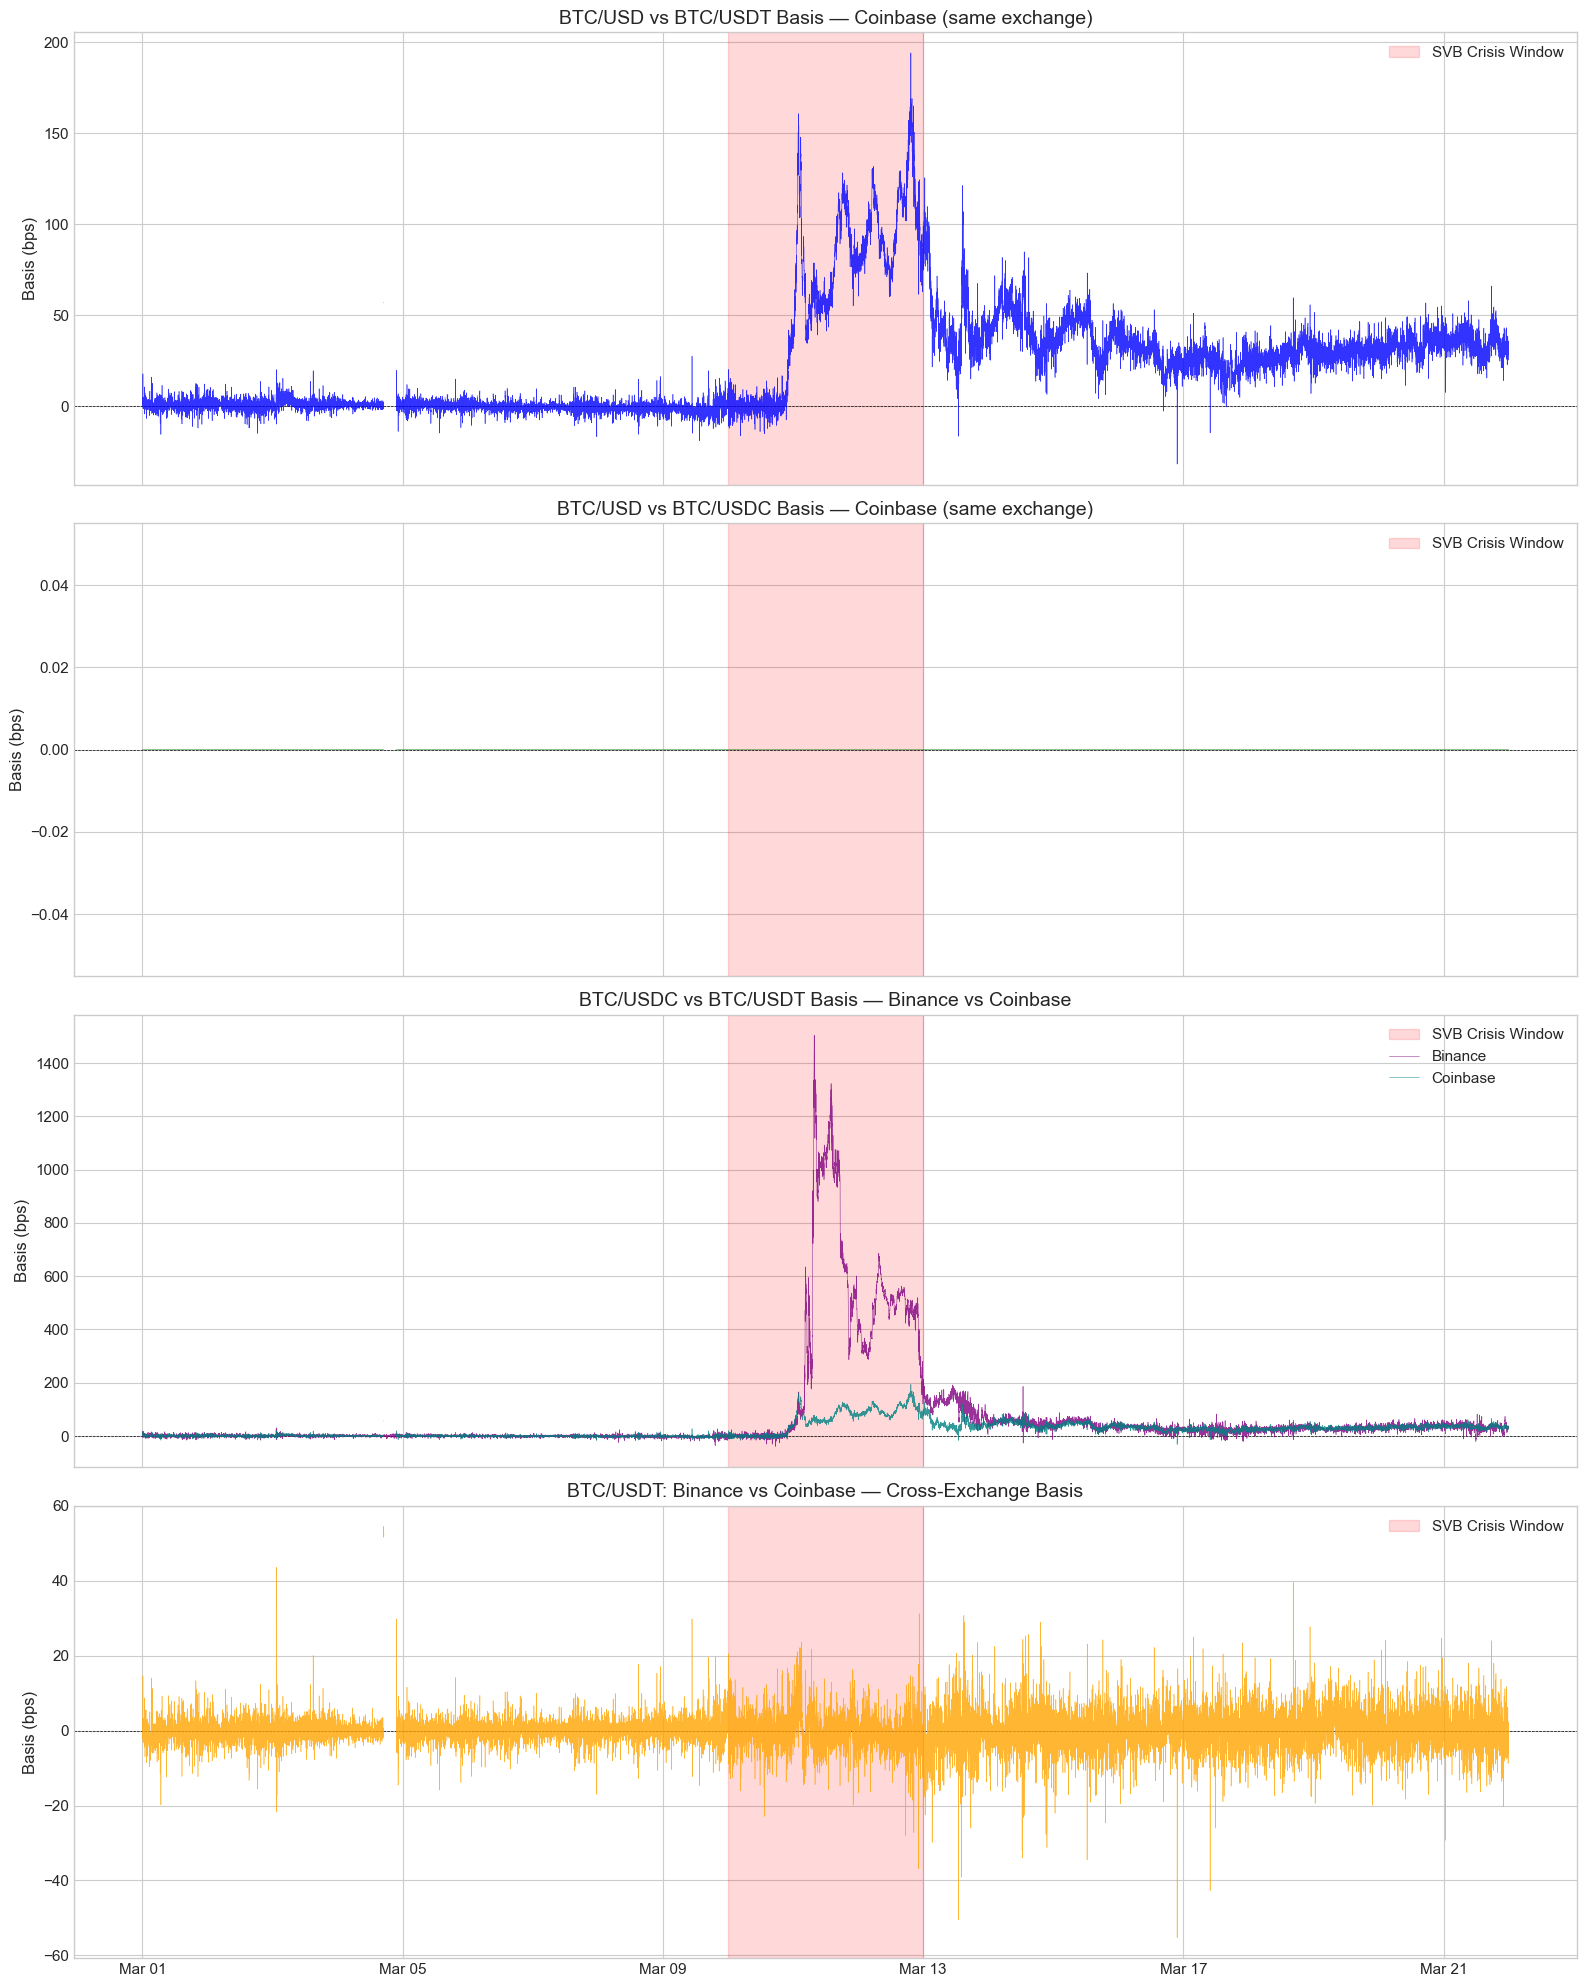

Figure saved: fig_cross_currency_basis.png


In [66]:
# ============================================================
# Cell 9: Cross-currency basis — same exchange (Coinbase)
# ============================================================

# Basis: BTC/USD vs BTC/USDT on Coinbase
basis_usdt_coinbase = (closes['implied_usdt_usd_coinbase'] - 1) * 1e4
basis_usdt_coinbase.name = 'USDT basis (bps) [Coinbase]'

# Basis: BTC/USD vs BTC/USDC on Coinbase
basis_usdc_coinbase = (closes['implied_usdc_usd_coinbase'] - 1) * 1e4
basis_usdc_coinbase.name = 'USDC basis (bps) [Coinbase]'

# Basis: BTC/USDT vs BTC/USDC on Binance
basis_usdt_usdc_binance = (closes['implied_usdt_usdc_binance'] - 1) * 1e4
basis_usdt_usdc_binance.name = 'USDT/USDC basis (bps) [Binance]'

# Basis: BTC/USDT vs BTC/USDC on Coinbase
basis_usdt_usdc_coinbase = (closes['implied_usdt_usdc_coinbase'] - 1) * 1e4
basis_usdt_usdc_coinbase.name = 'USDT/USDC basis (bps) [Coinbase]'

# Cross-exchange basis: Binance BTC/USDT vs Coinbase BTC/USDT
basis_cross_exchange = (closes['binance_btcusdt'] / closes['coinbase_btcusdt'] - 1) * 1e4
basis_cross_exchange.name = 'Binance vs Coinbase BTC/USDT (bps)'

fig, axes = plt.subplots(4, 1, figsize=(16, 20), sharex=True)

# SVB event shading
svb_start = pd.Timestamp('2023-03-10', tz='UTC')
svb_end = pd.Timestamp('2023-03-13', tz='UTC')

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis Window')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

axes[0].plot(basis_usdt_coinbase.index, basis_usdt_coinbase, linewidth=0.4, alpha=0.8, color='blue')
axes[0].set_title('BTC/USD vs BTC/USDT Basis — Coinbase (same exchange)')
axes[0].set_ylabel('Basis (bps)')

axes[1].plot(basis_usdc_coinbase.index, basis_usdc_coinbase, linewidth=0.4, alpha=0.8, color='green')
axes[1].set_title('BTC/USD vs BTC/USDC Basis — Coinbase (same exchange)')
axes[1].set_ylabel('Basis (bps)')

axes[2].plot(basis_usdt_usdc_binance.index, basis_usdt_usdc_binance, linewidth=0.4, alpha=0.8, color='purple', label='Binance')
axes[2].plot(basis_usdt_usdc_coinbase.index, basis_usdt_usdc_coinbase, linewidth=0.4, alpha=0.8, color='teal', label='Coinbase')
axes[2].set_title('BTC/USDC vs BTC/USDT Basis — Binance vs Coinbase')
axes[2].set_ylabel('Basis (bps)')

axes[3].plot(basis_cross_exchange.index, basis_cross_exchange, linewidth=0.4, alpha=0.8, color='orange')
axes[3].set_title('BTC/USDT: Binance vs Coinbase — Cross-Exchange Basis')
axes[3].set_ylabel('Basis (bps)')

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig_cross_currency_basis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_cross_currency_basis.png")


In [67]:
# ============================================================
# Cell 10: Basis statistics by regime (pre-crisis, crisis, post-crisis)
# ============================================================

regimes = {
    'Pre-SVB (Mar 1-9)': (pd.Timestamp('2023-03-01', tz='UTC'), pd.Timestamp('2023-03-10', tz='UTC')),
    'SVB Crisis (Mar 10-13)': (pd.Timestamp('2023-03-10', tz='UTC'), pd.Timestamp('2023-03-14', tz='UTC')),
    'Post-SVB (Mar 14-21)': (pd.Timestamp('2023-03-14', tz='UTC'), pd.Timestamp('2023-03-22', tz='UTC')),
}

basis_series = {
    'USDT basis (Coinbase)': basis_usdt_coinbase,
    'USDC basis (Coinbase)': basis_usdc_coinbase,
    'USDT/USDC basis (Binance)': basis_usdt_usdc_binance,
    'USDT/USDC basis (Coinbase)': basis_usdt_usdc_coinbase,
    'Cross-exch BTC/USDT': basis_cross_exchange,
}

regime_stats = []
for regime_name, (t0, t1) in regimes.items():
    for basis_name, bs in basis_series.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)].dropna()
        regime_stats.append({
            'Regime': regime_name,
            'Basis': basis_name,
            'Mean (bps)': subset.mean(),
            'Std (bps)': subset.std(),
            'Min (bps)': subset.min(),
            'Max (bps)': subset.max(),
            'Median (bps)': subset.median(),
            'Skewness': subset.skew(),
            'Kurtosis': subset.kurtosis(),
            'N obs': len(subset),
        })

regime_df = pd.DataFrame(regime_stats)
regime_df.set_index(['Regime', 'Basis'], inplace=True)
regime_df.round(2)


Mean (bps)  Std (bps)  \
Regime                 Basis                                               
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)             0.28       2.95   
                       USDC basis (Coinbase)             0.00       0.00   
                       USDT/USDC basis (Binance)         0.32       3.83   
                       USDT/USDC basis (Coinbase)        0.28       2.95   
                       Cross-exch BTC/USDT               0.01       2.82   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)            57.13      42.13   
                       USDC basis (Coinbase)             0.00       0.00   
                       USDT/USDC basis (Binance)       308.08     332.80   
                       USDT/USDC basis (Coinbase)       57.13      42.13   
                       Cross-exch BTC/USDT              -0.33       5.11   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)            32.97       9.93   
                       USDC basis (Coinbase)             0.00       0.00   
                       USDT/USDC basis (Binance)        34.01      14.09   
                       USDT/USDC basis (Coinbase)       32.97       9.93   
                       Cross-exch BTC/USDT               0.17       4.83   

                                                   Min (bps)  Max (bps)  \
Regime                 Basis                                              
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)          -18.83      56.90   
                       USDC basis (Coinbase)            0.00       0.00   
                       USDT/USDC basis (Binance)      -35.97      30.91   
                       USDT/USDC basis (Coinbase)     -18.83      56.90   
                       Cross-exch BTC/USDT            -21.70      54.53   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)          -16.41     194.09   
                       USDC basis (Coinbase)            0.00       0.00   
                       USDT/USDC basis (Binance)      -38.83    1504.47   
                       USDT/USDC basis (Coinbase)     -16.41     194.09   
                       Cross-exch BTC/USDT            -50.51      31.22   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)          -31.66      84.89   
                       USDC basis (Coinbase)            0.00       0.00   
                       USDT/USDC basis (Binance)      -26.54     186.57   
                       USDT/USDC basis (Coinbase)     -31.66      84.89   
                       Cross-exch BTC/USDT            -55.26      39.56   

                                                   Median (bps)  Skewness  \
Regime                 Basis                                                
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)               0.27      3.59   
                       USDC basis (Coinbase)               0.00      0.00   
                       USDT/USDC basis (Binance)           0.32     -0.14   
                       USDT/USDC basis (Coinbase)          0.27      3.59   
                       Cross-exch BTC/USDT                -0.07      3.89   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)              55.32      0.17   
                       USDC basis (Coinbase)               0.00      0.00   
                       USDT/USDC basis (Binance)         144.53      1.16   
                       USDT/USDC basis (Coinbase)         55.32      0.17   
                       Cross-exch BTC/USDT                -0.41     -0.16   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)              31.59      0.73   
                       USDC basis (Coinbase)               0.00      0.00   
                       USDT/USDC basis (Binance)          32.67      0.42   
                       USDT/USDC basis (Coinbase)         31.59      0.73   
                       Cross-exch BTC/USDT                 0.16     -0.19   

                                                   Kurtosis  N obs  
Regime                 Basis                                        
Pre-SVB (Mar 1-9)      USDT basis 

---
## 4. Stablecoin Dynamics: USDC De-Peg Analysis

On March 10, 2023, Circle disclosed that $3.3B of USDC reserves were held at the failing Silicon Valley Bank. USDC lost its dollar peg, trading as low as ~$0.87 before recovering on March 13 after the US government guaranteed all SVB deposits.

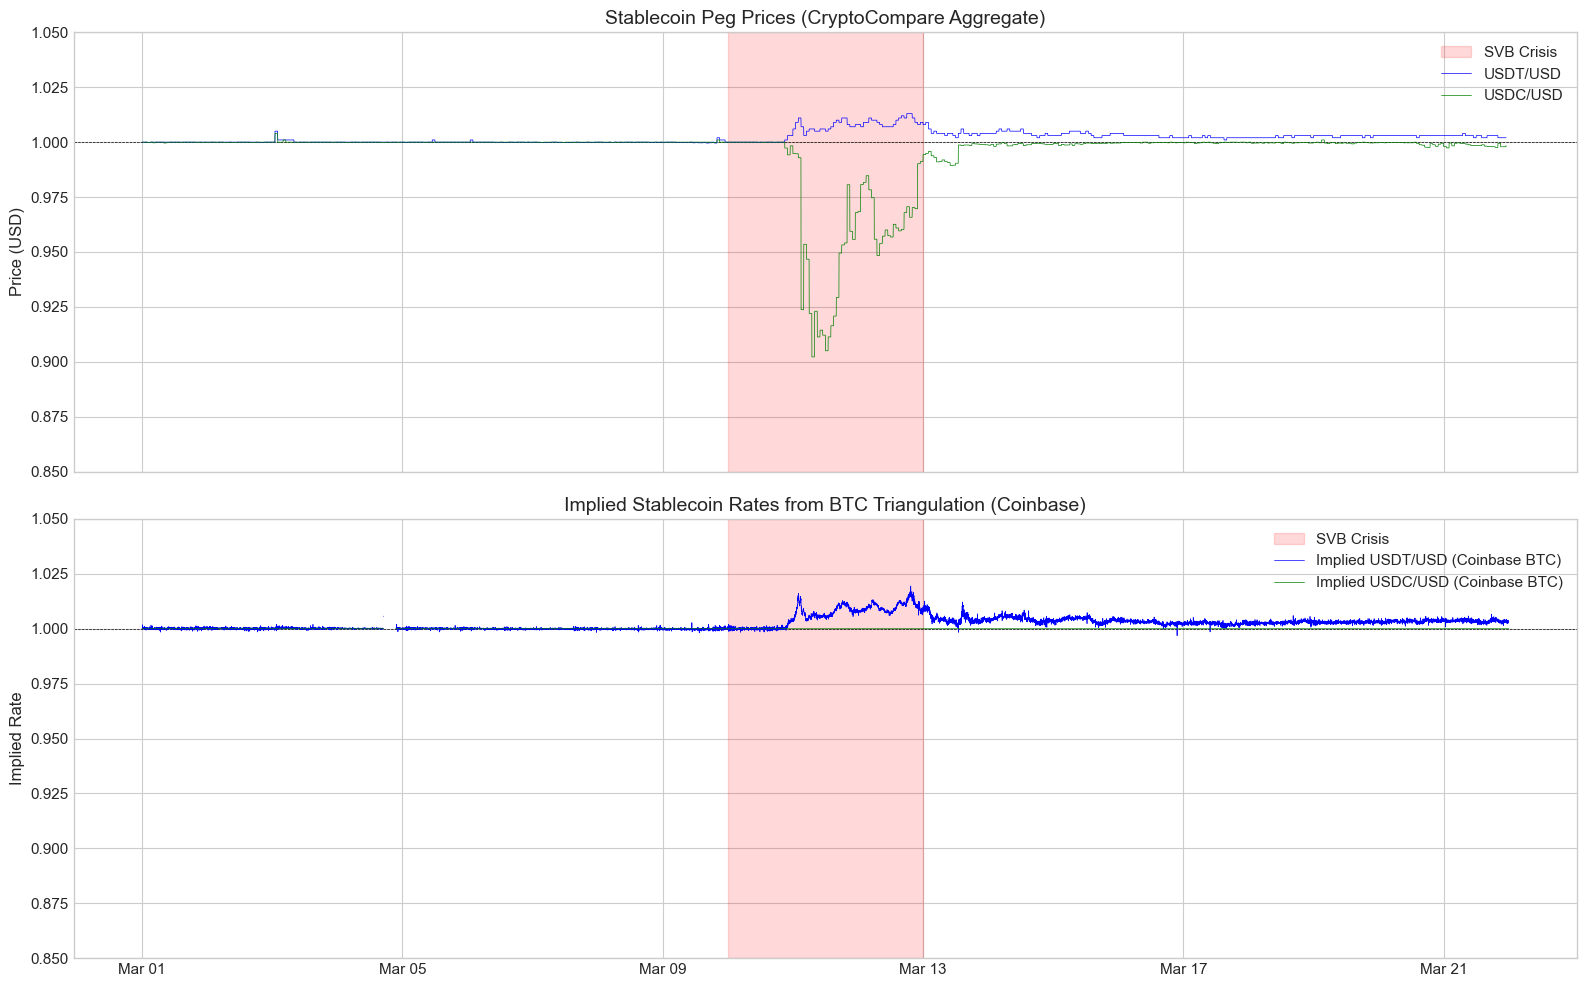

Figure saved: fig_stablecoin_peg.png


In [68]:
# ============================================================
# Cell 11: Stablecoin peg prices over time
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Direct peg data from CryptoCompare
ax = axes[0]
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
if not usdt_usd.empty:
    ax.plot(usdt_usd.index, usdt_usd['close'], linewidth=0.5, label='USDT/USD', color='blue')
if not usdc_usd.empty:
    ax.plot(usdc_usd.index, usdc_usd['close'], linewidth=0.5, label='USDC/USD', color='green')
ax.set_title('Stablecoin Peg Prices (CryptoCompare Aggregate)')
ax.set_ylabel('Price (USD)')
ax.legend()
ax.set_ylim(0.85, 1.05)

# Implied stablecoin rates from BTC triangulation (Coinbase)
ax = axes[1]
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes.index, closes['implied_usdt_usd_coinbase'], linewidth=0.5, label='Implied USDT/USD (Coinbase BTC)', color='blue')
ax.plot(closes.index, closes['implied_usdc_usd_coinbase'], linewidth=0.5, label='Implied USDC/USD (Coinbase BTC)', color='green')
ax.set_title('Implied Stablecoin Rates from BTC Triangulation (Coinbase)')
ax.set_ylabel('Implied Rate')
ax.legend()
ax.set_ylim(0.85, 1.05)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_stablecoin_peg.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_stablecoin_peg.png")

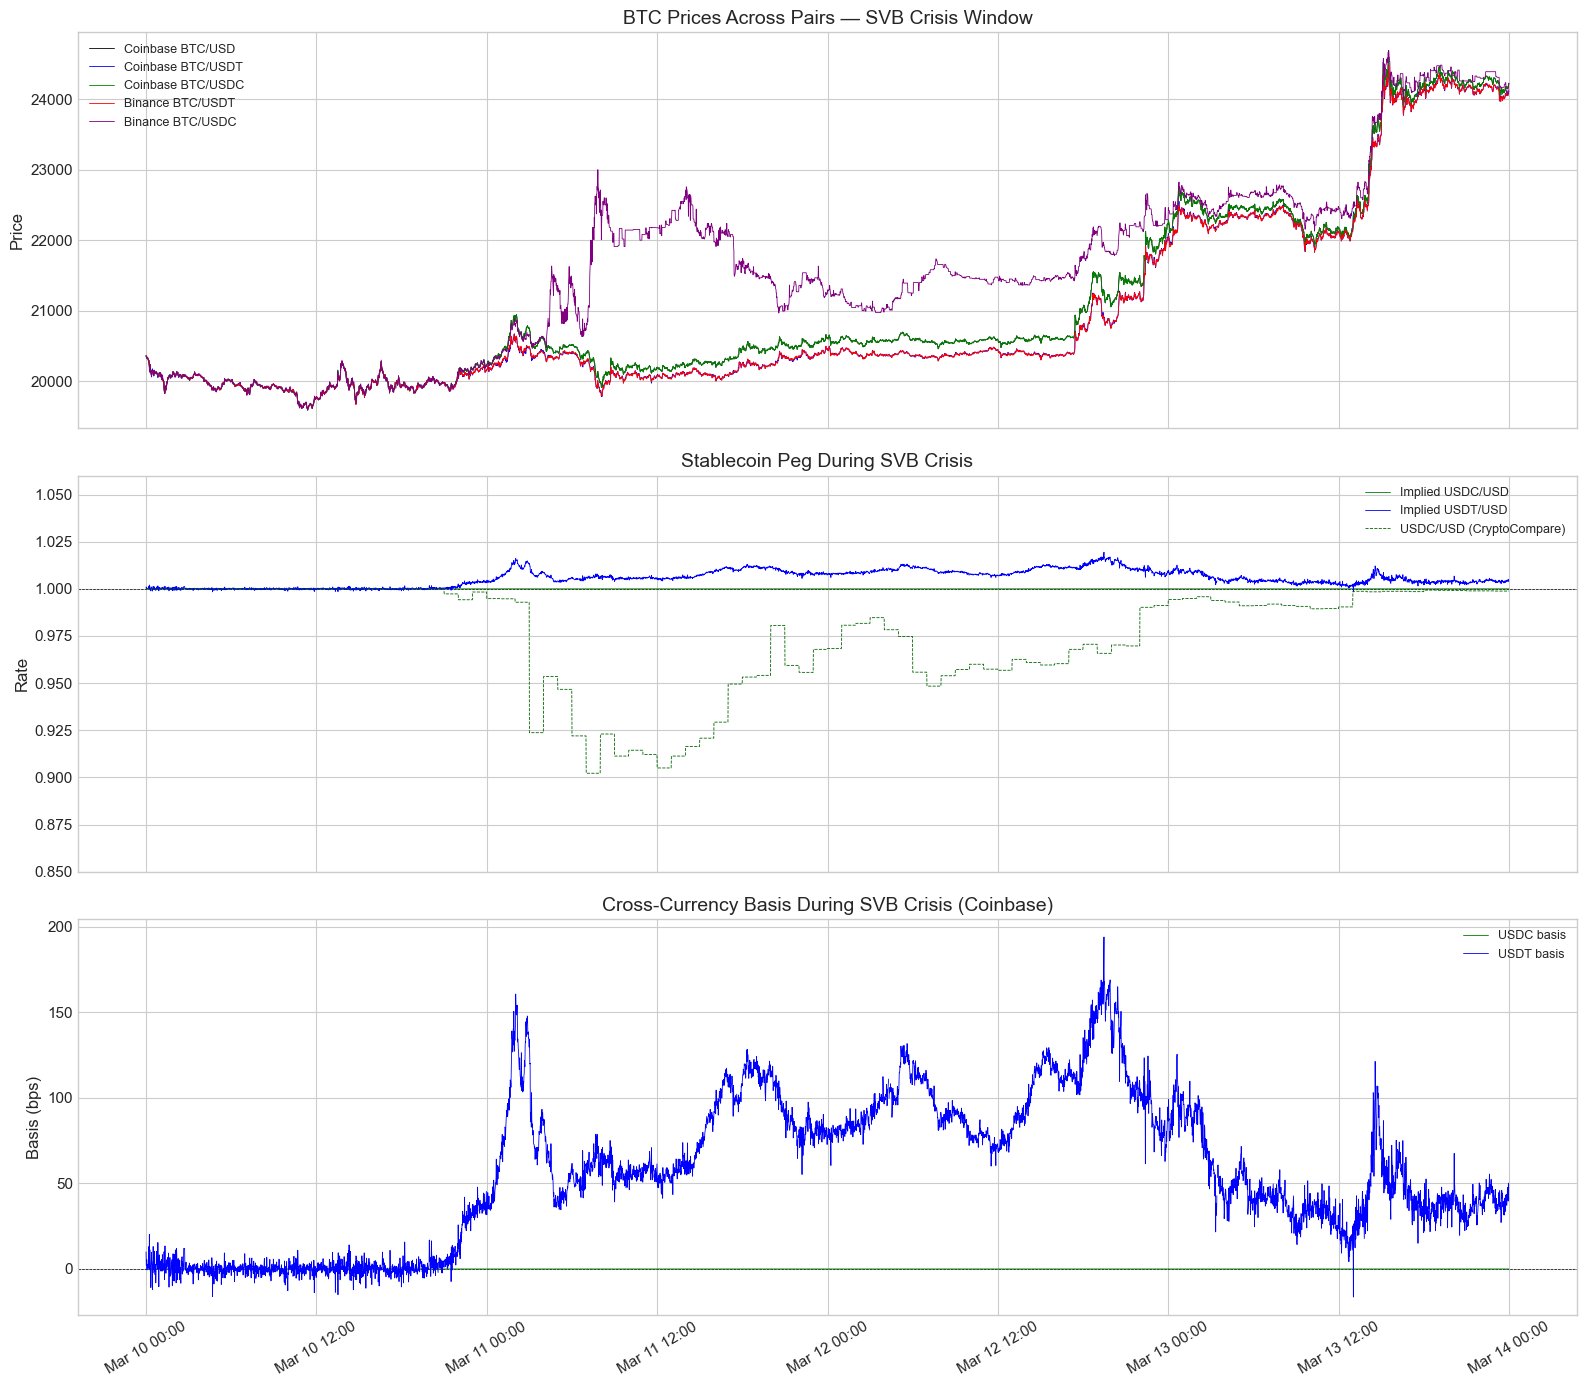

Figure saved: fig_svb_crisis_zoom.png


In [69]:
# ============================================================
# Cell 12: Zoomed-in view of the USDC de-peg event (March 10-13)
# ============================================================

zoom_start = pd.Timestamp('2023-03-10 00:00', tz='UTC')
zoom_end = pd.Timestamp('2023-03-14 00:00', tz='UTC')
mask = (closes.index >= zoom_start) & (closes.index < zoom_end)

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# Panel 1: BTC prices across pairs
ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'Coinbase BTC/USD', 'black'),
    ('coinbase_btcusdt', 'Coinbase BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'Coinbase BTC/USDC', 'green'),
    ('binance_btcusdt', 'Binance BTC/USDT', 'red'),
    ('binance_btcusdc', 'Binance BTC/USDC', 'purple'),
]:
    ax.plot(closes.loc[mask, col], linewidth=0.6, label=label, color=color)
ax.set_title('BTC Prices Across Pairs — SVB Crisis Window')
ax.set_ylabel('Price')
ax.legend(fontsize=9)

# Panel 2: Stablecoin rates
ax = axes[1]
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes.loc[mask, 'implied_usdc_usd_coinbase'], linewidth=0.6, label='Implied USDC/USD', color='green')
ax.plot(closes.loc[mask, 'implied_usdt_usd_coinbase'], linewidth=0.6, label='Implied USDT/USD', color='blue')
if not usdc_usd.empty:
    usdc_zoom = usdc_usd.loc[(usdc_usd.index >= zoom_start) & (usdc_usd.index < zoom_end)]
    ax.plot(usdc_zoom.index, usdc_zoom['close'], linewidth=0.6, label='USDC/USD (CryptoCompare)', color='darkgreen', linestyle='--')
ax.set_title('Stablecoin Peg During SVB Crisis')
ax.set_ylabel('Rate')
ax.legend(fontsize=9)
ax.set_ylim(0.85, 1.06)

# Panel 3: USDC basis (BTC/USD vs BTC/USDC) on Coinbase
ax = axes[2]
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_usdc_coinbase[mask], linewidth=0.6, color='green', label='USDC basis')
ax.plot(basis_usdt_coinbase[mask], linewidth=0.6, color='blue', label='USDT basis')
ax.set_title('Cross-Currency Basis During SVB Crisis (Coinbase)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=9)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.tight_layout()
plt.savefig('fig_svb_crisis_zoom.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_svb_crisis_zoom.png")

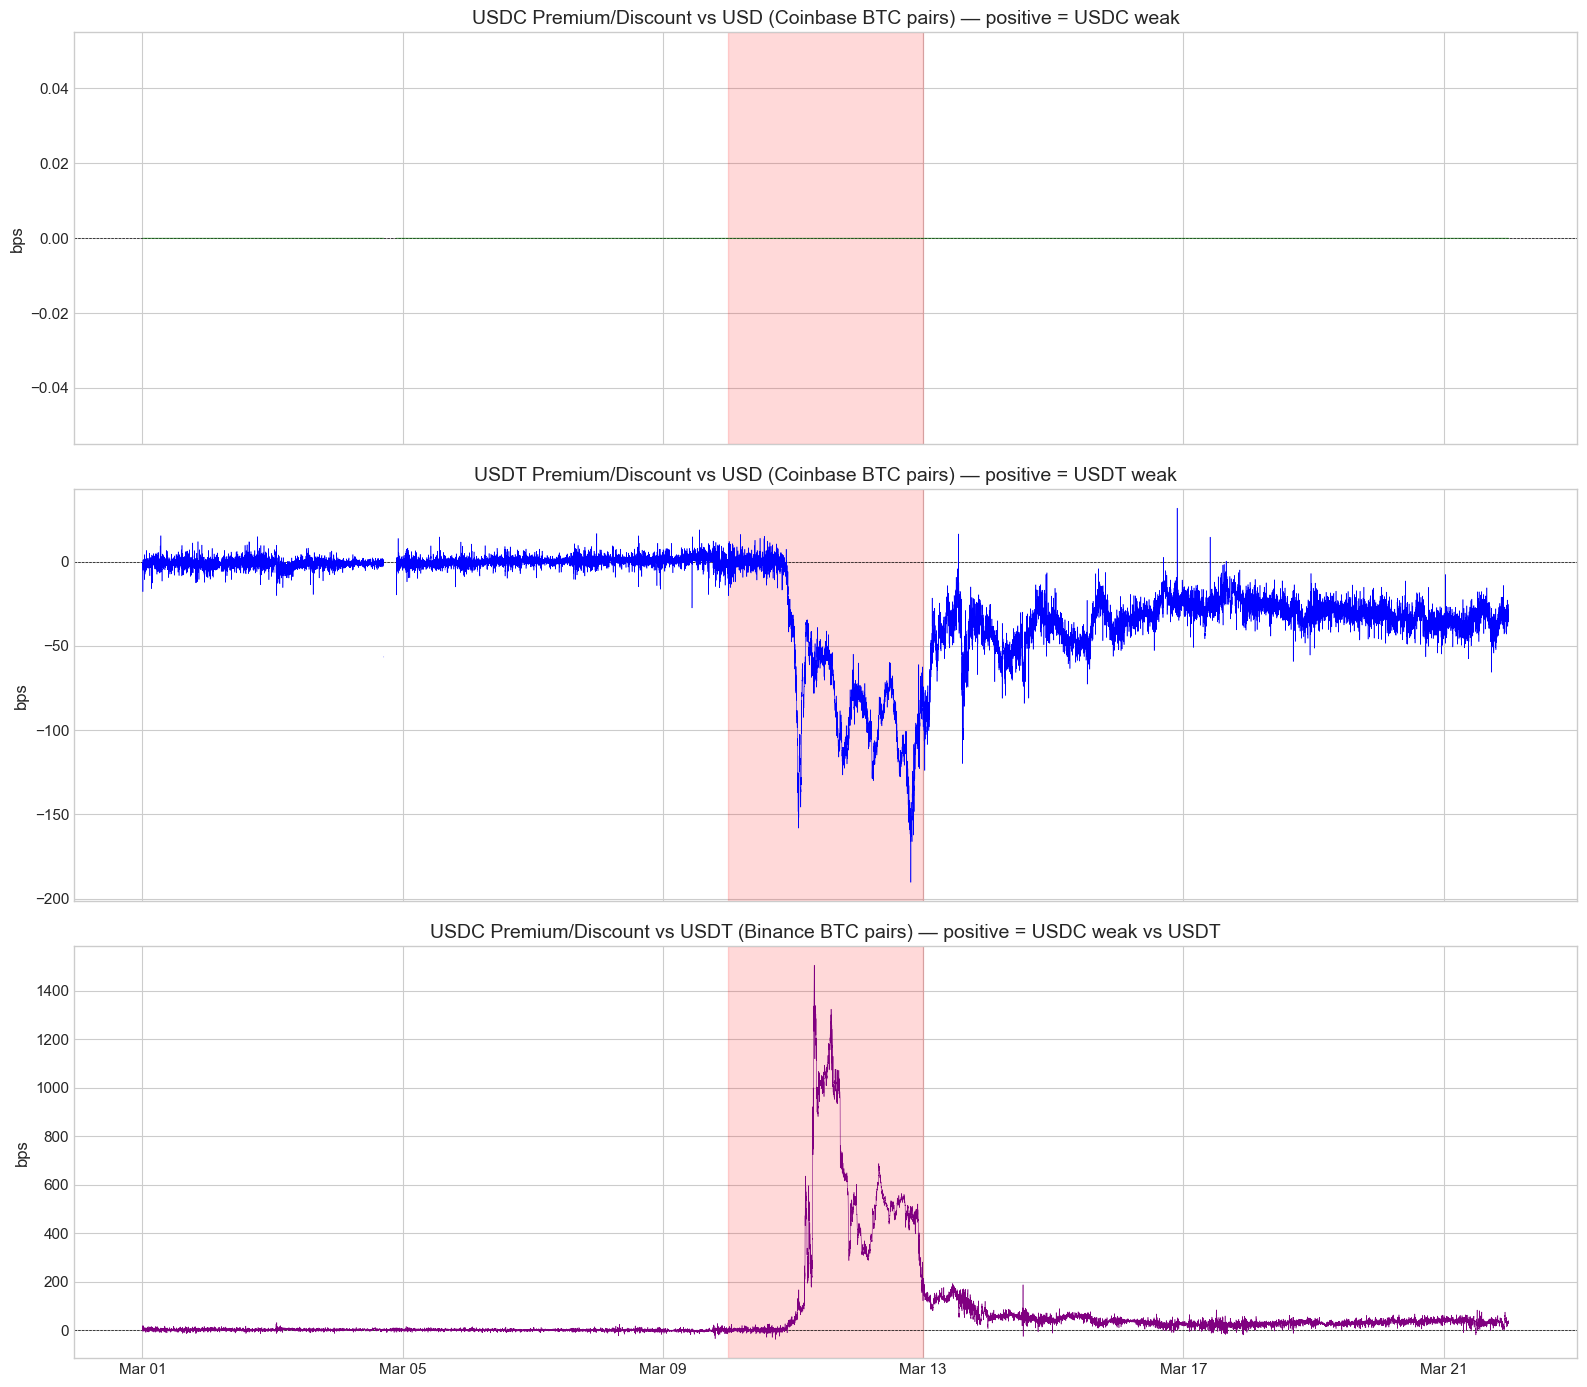

Figure saved: fig_stablecoin_premium_discount.png


In [70]:
# ============================================================
# Cell 13: Premium/Discount analysis — USDT vs USDC across exchanges
# ============================================================

# USDC premium/discount on Coinbase = (BTC_USDC / BTC_USD - 1) * 10000
# When USDC < $1, BTC/USDC > BTC/USD → positive premium in USDC terms
usdc_premium_coinbase = (closes['coinbase_btcusdc'] / closes['coinbase_btcusd'] - 1) * 1e4
usdt_premium_coinbase = (closes['coinbase_btcusdt'] / closes['coinbase_btcusd'] - 1) * 1e4

# On Binance: BTC/USDC vs BTC/USDT
usdc_premium_vs_usdt_binance = (closes['binance_btcusdc'] / closes['binance_btcusdt'] - 1) * 1e4

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

axes[0].plot(usdc_premium_coinbase, linewidth=0.4, color='green')
axes[0].set_title('USDC Premium/Discount vs USD (Coinbase BTC pairs) — positive = USDC weak')
axes[0].set_ylabel('bps')

axes[1].plot(usdt_premium_coinbase, linewidth=0.4, color='blue')
axes[1].set_title('USDT Premium/Discount vs USD (Coinbase BTC pairs) — positive = USDT weak')
axes[1].set_ylabel('bps')

axes[2].plot(usdc_premium_vs_usdt_binance, linewidth=0.4, color='purple')
axes[2].set_title('USDC Premium/Discount vs USDT (Binance BTC pairs) — positive = USDC weak vs USDT')
axes[2].set_ylabel('bps')

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_stablecoin_premium_discount.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_stablecoin_premium_discount.png")

USDC/USD Implied Rate During SVB Crisis (Mar 10-13):
  Min rate:  1.0000 (max discount: 0.00%)
  Max rate:  1.0000
  Mean rate: 1.0000
  Time of min: 2023-03-10 00:00:00+00:00


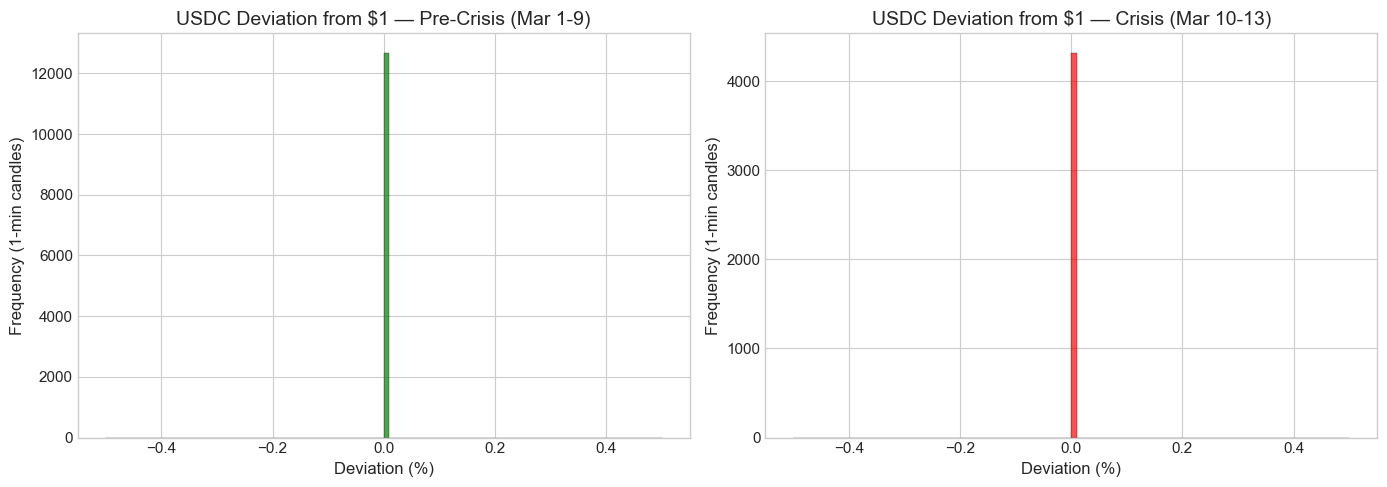

In [71]:
# ============================================================
# Cell 14: USDC de-peg severity — minute-level max deviation
# ============================================================

# Focus on the implied USDC/USD rate from Coinbase triangulation
usdc_rate = closes['implied_usdc_usd_coinbase'].dropna()
usdc_deviation = (usdc_rate - 1.0) * 100  # in percentage points

crisis_mask = (usdc_deviation.index >= svb_start) & (usdc_deviation.index < svb_end)
crisis_dev = usdc_deviation[crisis_mask]

print("USDC/USD Implied Rate During SVB Crisis (Mar 10-13):")
print(f"  Min rate:  {usdc_rate[crisis_mask].min():.4f} (max discount: {crisis_dev.min():.2f}%)")
print(f"  Max rate:  {usdc_rate[crisis_mask].max():.4f}")
print(f"  Mean rate: {usdc_rate[crisis_mask].mean():.4f}")
print(f"  Time of min: {usdc_rate[crisis_mask].idxmin()}")

# Distribution of deviations during crisis vs normal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pre_crisis_dev = usdc_deviation[(usdc_deviation.index >= START_DT) & (usdc_deviation.index < svb_start)].dropna()
crisis_dev_clean = crisis_dev.dropna()

axes[0].hist(pre_crisis_dev, bins=100, color='green', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0].set_title('USDC Deviation from $1 — Pre-Crisis (Mar 1-9)')
axes[0].set_xlabel('Deviation (%)')
axes[0].set_ylabel('Frequency (1-min candles)')

axes[1].hist(crisis_dev_clean, bins=100, color='red', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[1].set_title('USDC Deviation from $1 — Crisis (Mar 10-13)')
axes[1].set_xlabel('Deviation (%)')
axes[1].set_ylabel('Frequency (1-min candles)')

plt.tight_layout()
plt.savefig('fig_usdc_deviation_hist.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Liquidity & Fragmentation Analysis

We examine liquidity differences across quote currencies and exchanges using:
1. **Trading volume** (BTC per minute)
2. **Spread proxy** (high - low within each 1-minute candle)
3. **Realized volatility** (standard deviation of 1-minute returns)
4. **Trade count** (Binance only)

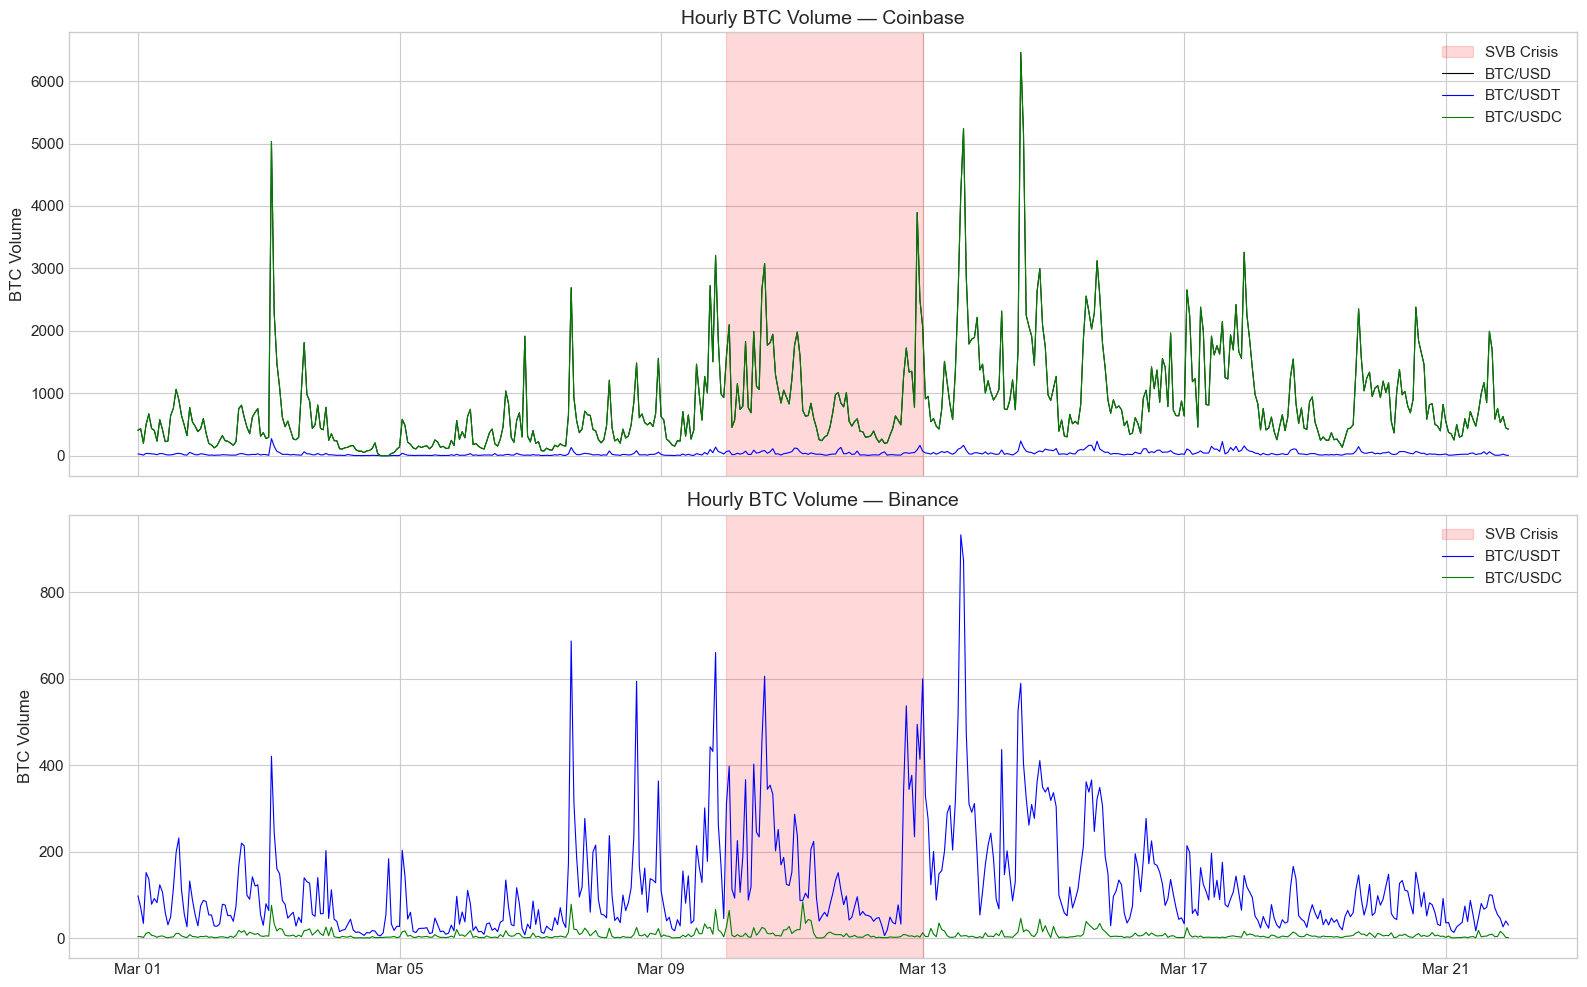

In [72]:
# ============================================================
# Cell 15: Volume comparison across pairs
# ============================================================

# Hourly volume aggregation for cleaner visualization
hourly_vol = volumes[btc_cols].resample('1h').sum()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

# Coinbase pairs
ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_vol[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly BTC Volume — Coinbase')
ax.set_ylabel('BTC Volume')
ax.legend()

# Binance pairs
ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_vol[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly BTC Volume — Binance')
ax.set_ylabel('BTC Volume')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_volume_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

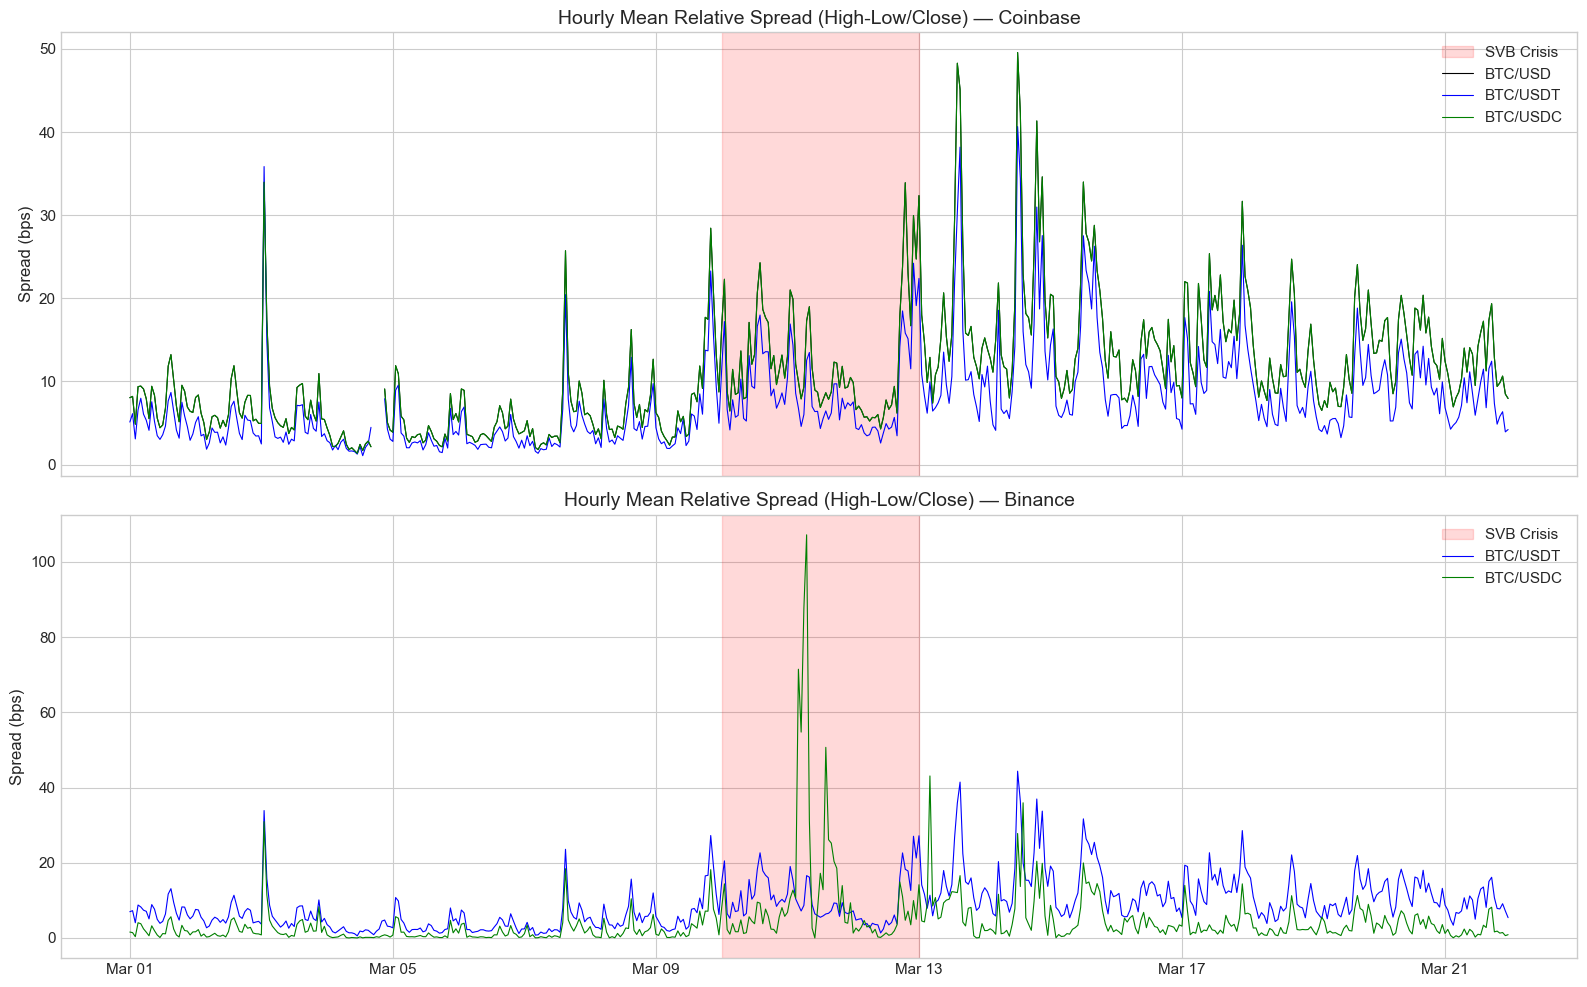

In [73]:
# ============================================================
# Cell 16: Spread proxy analysis
# ============================================================

# Relative spread = (high - low) / close  (in bps)
rel_spreads = pd.DataFrame()
for col in btc_cols:
    rel_spreads[col] = (spreads[col] / closes[col]) * 1e4  # bps

# Hourly mean relative spread
hourly_spread = rel_spreads.resample('1h').mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_spread[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly Mean Relative Spread (High-Low/Close) — Coinbase')
ax.set_ylabel('Spread (bps)')
ax.legend()

ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_spread[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly Mean Relative Spread (High-Low/Close) — Binance')
ax.set_ylabel('Spread (bps)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_spread_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

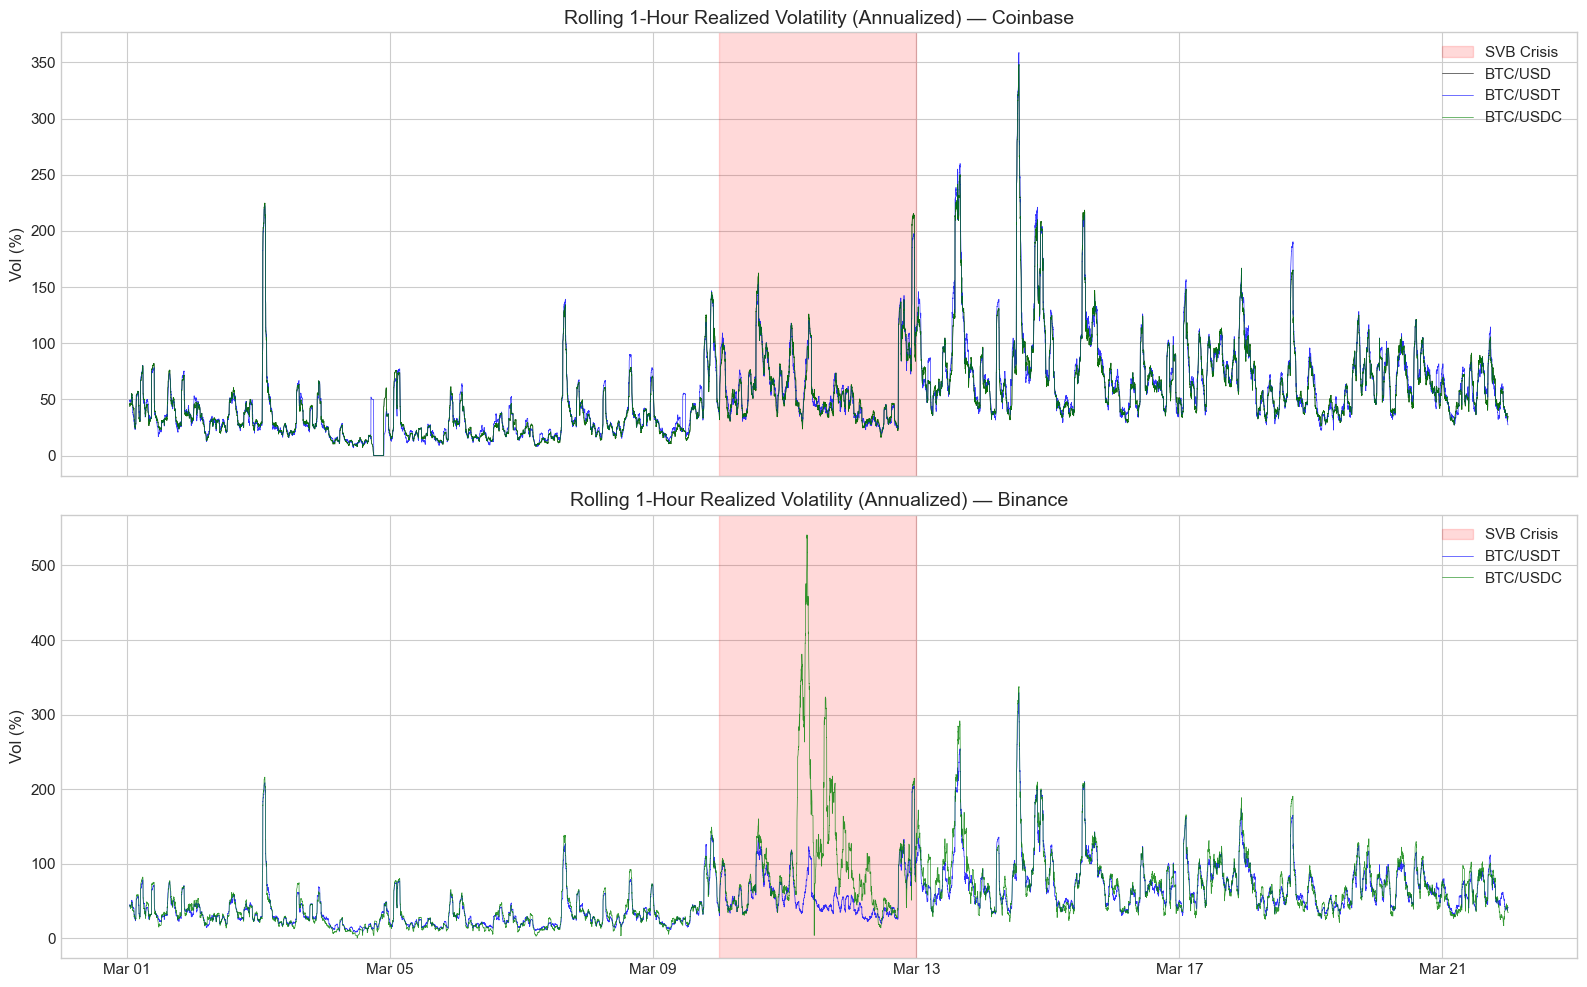

In [74]:
# ============================================================
# Cell 17: Realized volatility — rolling 1-hour (60 x 1-min returns)
# ============================================================

# Annualized realized vol from 1-min returns (sqrt(525600) ~ 725)
rolling_vol = returns[btc_cols].rolling(60).std() * np.sqrt(525600) * 100  # annualized %

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(rolling_vol[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('Rolling 1-Hour Realized Volatility (Annualized) — Coinbase')
ax.set_ylabel('Vol (%)')
ax.legend()

ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(rolling_vol[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('Rolling 1-Hour Realized Volatility (Annualized) — Binance')
ax.set_ylabel('Vol (%)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_realized_volatility.png', dpi=150, bbox_inches='tight')
plt.show()

In [75]:
# ============================================================
# Cell 18: Liquidity regime comparison table
# ============================================================

liq_stats = []
for regime_name, (t0, t1) in regimes.items():
    rmask = (volumes.index >= t0) & (volumes.index < t1)
    for col, nice in zip(btc_cols, nice_names):
        vol_sub = volumes.loc[rmask, col]
        spread_sub = rel_spreads.loc[rmask, col].dropna()
        ret_sub = returns.loc[rmask, col].dropna()
        liq_stats.append({
            'Regime': regime_name,
            'Pair': nice,
            'Mean Volume (BTC/min)': vol_sub.mean(),
            'Total Volume (BTC)': vol_sub.sum(),
            'Mean Rel Spread (bps)': spread_sub.mean(),
            'Median Rel Spread (bps)': spread_sub.median(),
            'Realized Vol (ann %)': ret_sub.std() * np.sqrt(525600) * 100,
        })

liq_df = pd.DataFrame(liq_stats)
liq_df.set_index(['Regime', 'Pair'], inplace=True)
liq_df.round(4)

Mean Volume (BTC/min)  \
Regime                 Pair                                       
Pre-SVB (Mar 1-9)      Binance BTC/USDT                  1.5071   
                       Binance BTC/USDC                  0.1234   
                       Coinbase BTC/USD                  8.2080   
                       Coinbase BTC/USDT                 0.3268   
                       Coinbase BTC/USDC                 8.2080   
SVB Crisis (Mar 10-13) Binance BTC/USDT                  3.4191   
                       Binance BTC/USDC                  0.1669   
                       Coinbase BTC/USD                 18.9007   
                       Coinbase BTC/USDT                 0.7544   
                       Coinbase BTC/USDC                18.9007   
Post-SVB (Mar 14-21)   Binance BTC/USDT                  2.0088   
                       Binance BTC/USDC                  0.1135   
                       Coinbase BTC/USD                 18.2904   
                       Coinbase BTC/USDT                 0.8396   
                       Coinbase BTC/USDC                18.2904   

                                          Total Volume (BTC)  \
Regime                 Pair                                    
Pre-SVB (Mar 1-9)      Binance BTC/USDT           19532.3629   
                       Binance BTC/USDC            1599.3375   
                       Coinbase BTC/USD          106376.1547   
                       Coinbase BTC/USDT           4235.5779   
                       Coinbase BTC/USDC         106376.1547   
SVB Crisis (Mar 10-13) Binance BTC/USDT           19693.7824   
                       Binance BTC/USDC             961.5197   
                       Coinbase BTC/USD          108867.8003   
                       Coinbase BTC/USDT           4345.5495   
                       Coinbase BTC/USDC         108867.8003   
Post-SVB (Mar 14-21)   Binance BTC/USDT           23141.3766   
                       Binance BTC/USDC            1307.9137   
                       Coinbase BTC/USD          210704.9189   
                       Coinbase BTC/USDT           9672.0742   
                       Coinbase BTC/USDC         210704.9189   

                                          Mean Rel Spread (bps)  \
Regime                 Pair                                       
Pre-SVB (Mar 1-9)      Binance BTC/USDT                  5.1958   
                       Binance BTC/USDC                  1.9887   
                       Coinbase BTC/USD                  6.2165   
                       Coinbase BTC/USDT                 4.8640   
                       Coinbase BTC/USDC                 6.2165   
SVB Crisis (Mar 10-13) Binance BTC/USDT                 11.3017   
                       Binance BTC/USDC                 10.7563   
                       Coinbase BTC/USD                 13.7520   
                       Coinbase BTC/USDT                 9.9541   
                       Coinbase BTC/USDC                13.7520   
Post-SVB (Mar 14-21)   Binance BTC/USDT                 12.3710   
                       Binance BTC/USDC                  4.2329   
                       Coinbase BTC/USD                 14.9523   
                       Coinbase BTC/USDT                10.7669   
                       Coinbase BTC/USDC                14.9523   

                                          Median Rel Spread (bps)  \
Regime                 Pair                                         
Pre-SVB (Mar 1-9)      Binance BTC/USDT                    3.6650   
                       Binance BTC/USDC                    0.0000   
                       Coinbase BTC/USD                    4.5884   
                       Coinbase BTC/USDT                   3.1830   
                       Coinbase BTC/USDC                   4.5884   
SVB Crisis (Mar 10-13) Binance BTC/USDT                    8.5209   
                       Binance BTC/USDC                    0.0047   
                       Coinbase BTC/USD             

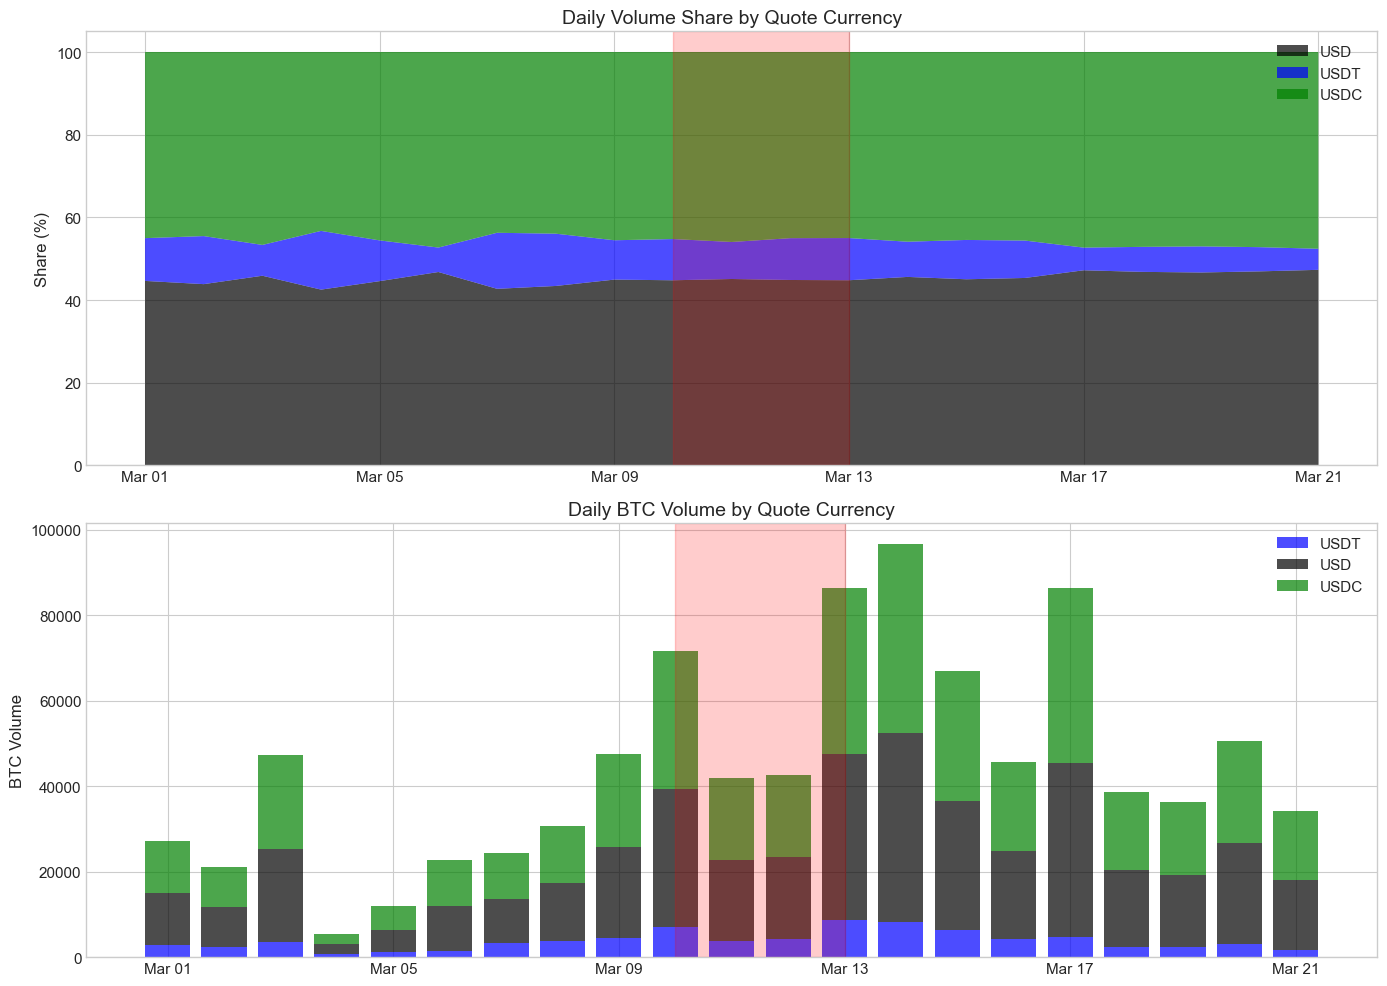

In [76]:
# ============================================================
# Cell 19: Volume share by quote currency over time
# ============================================================

# Aggregate volume by quote currency (across exchanges)
vol_by_quote = pd.DataFrame({
    'USD': volumes['coinbase_btcusd'],
    'USDT': volumes[['binance_btcusdt', 'coinbase_btcusdt']].sum(axis=1),
    'USDC': volumes[['binance_btcusdc', 'coinbase_btcusdc']].sum(axis=1),
})

# Daily volume shares
daily_vol = vol_by_quote.resample('1D').sum()
daily_share = daily_vol.div(daily_vol.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Stacked area chart of volume shares
ax = axes[0]
ax.stackplot(daily_share.index, daily_share['USD'], daily_share['USDT'], daily_share['USDC'],
             labels=['USD', 'USDT', 'USDC'], colors=['black', 'blue', 'green'], alpha=0.7)
ax.axvspan(svb_start, svb_end, alpha=0.2, color='red')
ax.set_title('Daily Volume Share by Quote Currency')
ax.set_ylabel('Share (%)')
ax.legend(loc='upper right')

# Absolute daily volume
ax = axes[1]
ax.bar(daily_vol.index, daily_vol['USDT'], width=0.8, label='USDT', color='blue', alpha=0.7)
ax.bar(daily_vol.index, daily_vol['USD'], width=0.8, bottom=daily_vol['USDT'], label='USD', color='black', alpha=0.7)
ax.bar(daily_vol.index, daily_vol['USDC'], width=0.8, bottom=daily_vol['USDT'] + daily_vol['USD'], label='USDC', color='green', alpha=0.7)
ax.axvspan(svb_start, svb_end, alpha=0.2, color='red')
ax.set_title('Daily BTC Volume by Quote Currency')
ax.set_ylabel('BTC Volume')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_volume_share.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Arbitrage & Transaction Cost Analysis

We examine whether the cross-currency basis represents a true arbitrage opportunity after accounting for:
- Exchange trading fees (typically 0.1% on Binance, 0.5-0.6% taker on Coinbase)
- Bid-ask spread costs (proxied by our high-low spread measure)
- Transfer/withdrawal fees and latency

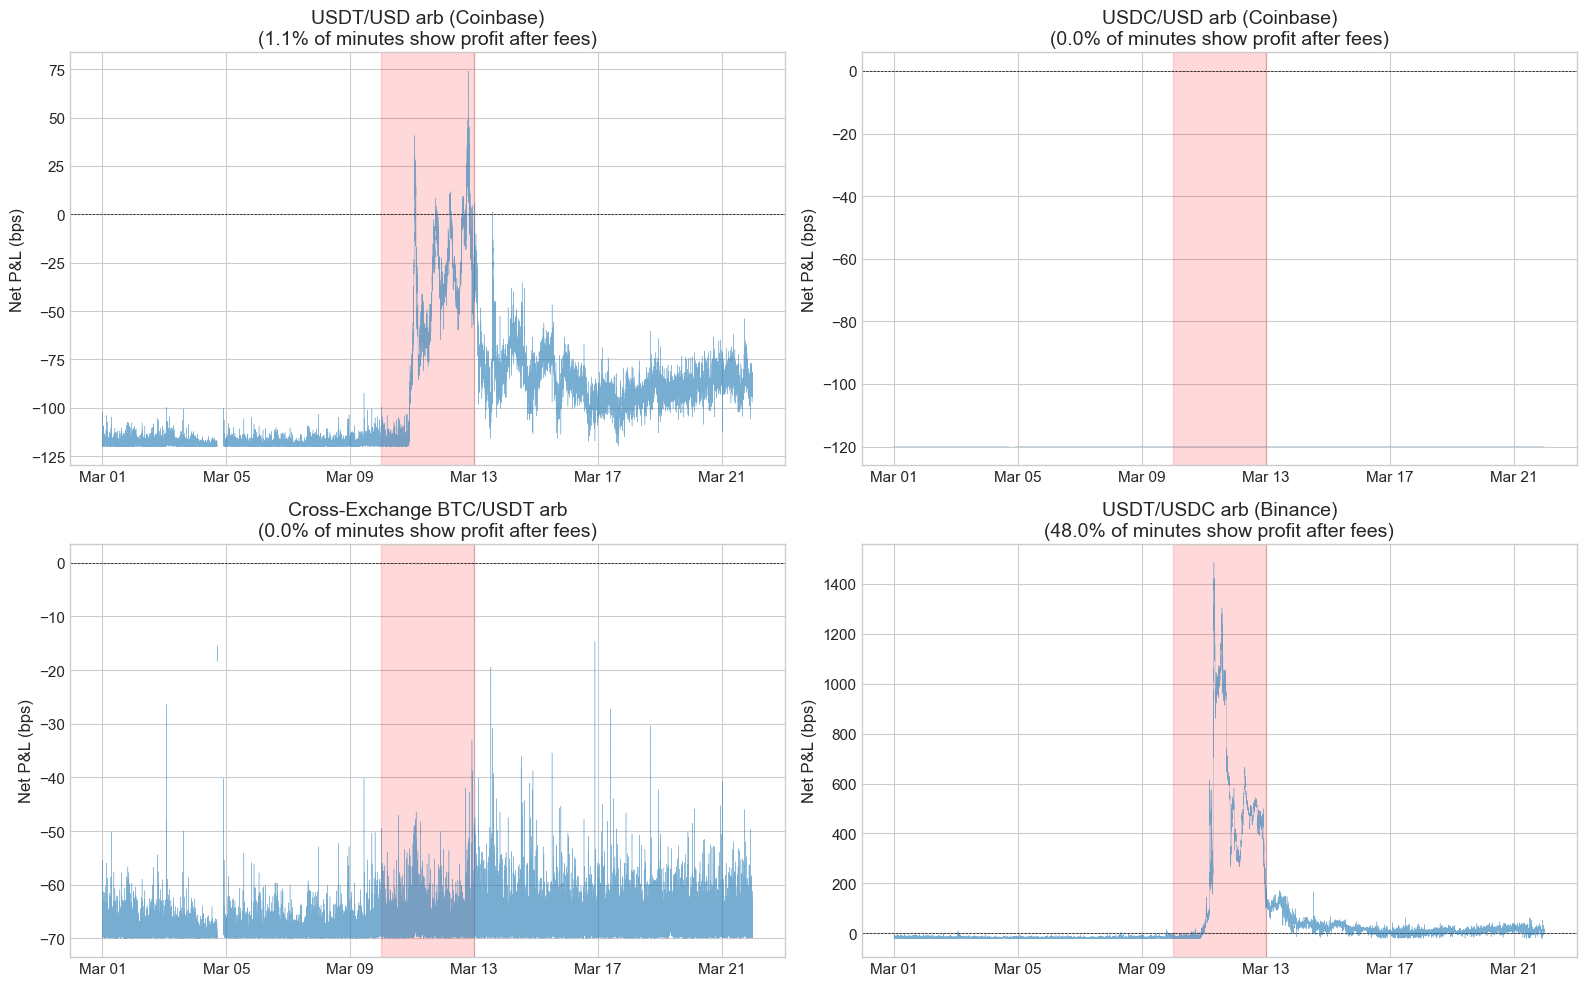


Arbitrage profitability summary (% of minutes with net positive P&L):
  USDT/USD arb (Coinbase)                 :   1.14% profitable  |  Mean net P&L when profitable: 17.3 bps
  USDC/USD arb (Coinbase)                 :   0.00% profitable  |  Mean net P&L when profitable: nan bps
  Cross-Exchange BTC/USDT arb             :   0.00% profitable  |  Mean net P&L when profitable: nan bps
  USDT/USDC arb (Binance)                 :  47.96% profitable  |  Mean net P&L when profitable: 128.1 bps


In [77]:
# ============================================================
# Cell 20: Arbitrage after transaction costs
# ============================================================

# Typical fee assumptions (in bps, round-trip)
FEE_BINANCE_RT = 20   # 10bps * 2 (taker-taker round trip)
FEE_COINBASE_RT = 120  # 60bps * 2 (taker fee on Coinbase Pro was ~0.5-0.6% in March 2023)
FEE_CROSS_EXCHANGE_RT = 70  # ~10bps Binance + 60bps Coinbase (one leg each)

# Same-exchange arb: BTC/USD vs BTC/USDT on Coinbase
arb_usdt_coinbase = basis_usdt_coinbase.abs() - FEE_COINBASE_RT
arb_usdc_coinbase = basis_usdc_coinbase.abs() - FEE_COINBASE_RT

# Cross-exchange arb: Binance BTC/USDT vs Coinbase BTC/USDT
arb_cross = basis_cross_exchange.abs() - FEE_CROSS_EXCHANGE_RT

# Binance internal: BTC/USDT vs BTC/USDC
arb_binance_internal = basis_usdt_usdc_binance.abs() - FEE_BINANCE_RT

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

arb_data = [
    (arb_usdt_coinbase, 'USDT/USD arb (Coinbase)', axes[0, 0]),
    (arb_usdc_coinbase, 'USDC/USD arb (Coinbase)', axes[0, 1]),
    (arb_cross, 'Cross-Exchange BTC/USDT arb', axes[1, 0]),
    (arb_binance_internal, 'USDT/USDC arb (Binance)', axes[1, 1]),
]

for arb, title, ax in arb_data:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    profitable = arb[arb > 0]
    pct_profitable = (arb > 0).mean() * 100
    ax.plot(arb, linewidth=0.3, alpha=0.6)
    ax.set_title(f'{title}\n({pct_profitable:.1f}% of minutes show profit after fees)')
    ax.set_ylabel('Net P&L (bps)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_arbitrage_after_fees.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nArbitrage profitability summary (% of minutes with net positive P&L):")
for arb, title, _ in arb_data:
    a = arb.dropna()
    print(f"  {title:40s}: {(a > 0).mean()*100:6.2f}% profitable  |  Mean net P&L when profitable: {a[a>0].mean():.1f} bps")

---
## 7. Correlation & Co-movement Analysis

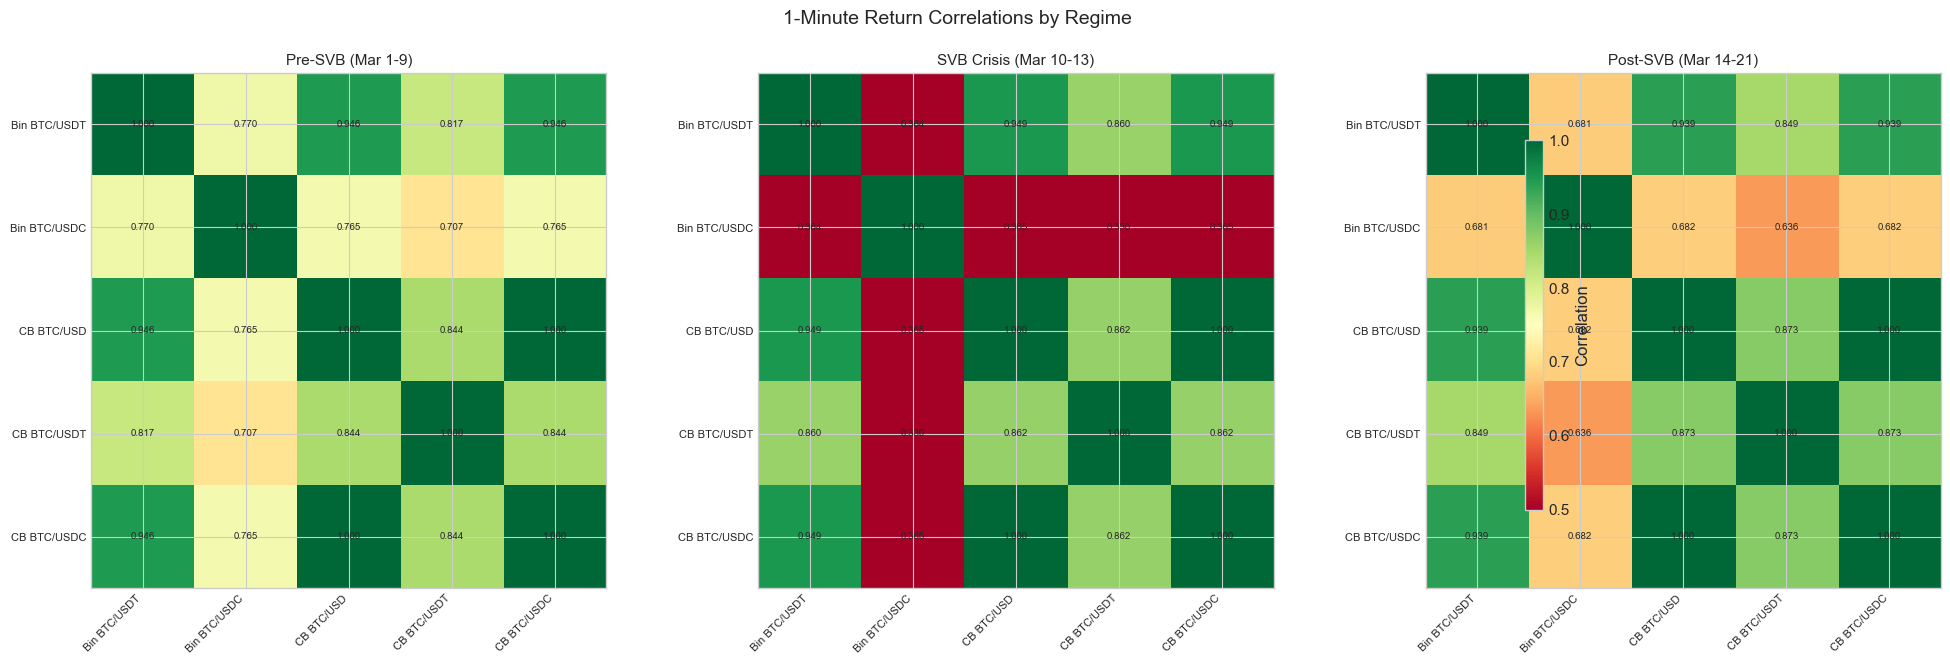

In [78]:
# ============================================================
# Cell 21: Return correlations across pairs and regimes
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (regime_name, (t0, t1)) in enumerate(regimes.items()):
    rmask = (returns.index >= t0) & (returns.index < t1)
    corr = returns.loc[rmask, btc_cols].corr()
    corr.index = nice_names
    corr.columns = nice_names
    
    ax = axes[idx]
    im = ax.imshow(corr.values, cmap='RdYlGn', vmin=0.5, vmax=1.0)
    ax.set_xticks(range(len(nice_names)))
    ax.set_yticks(range(len(nice_names)))
    ax.set_xticklabels([n.replace('Coinbase ', 'CB ').replace('Binance ', 'Bin ') for n in nice_names], rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([n.replace('Coinbase ', 'CB ').replace('Binance ', 'Bin ') for n in nice_names], fontsize=8)
    for i in range(len(nice_names)):
        for j in range(len(nice_names)):
            ax.text(j, i, f'{corr.values[i,j]:.3f}', ha='center', va='center', fontsize=7)
    ax.set_title(regime_name, fontsize=11)

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Correlation')
plt.suptitle('1-Minute Return Correlations by Regime', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fig_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

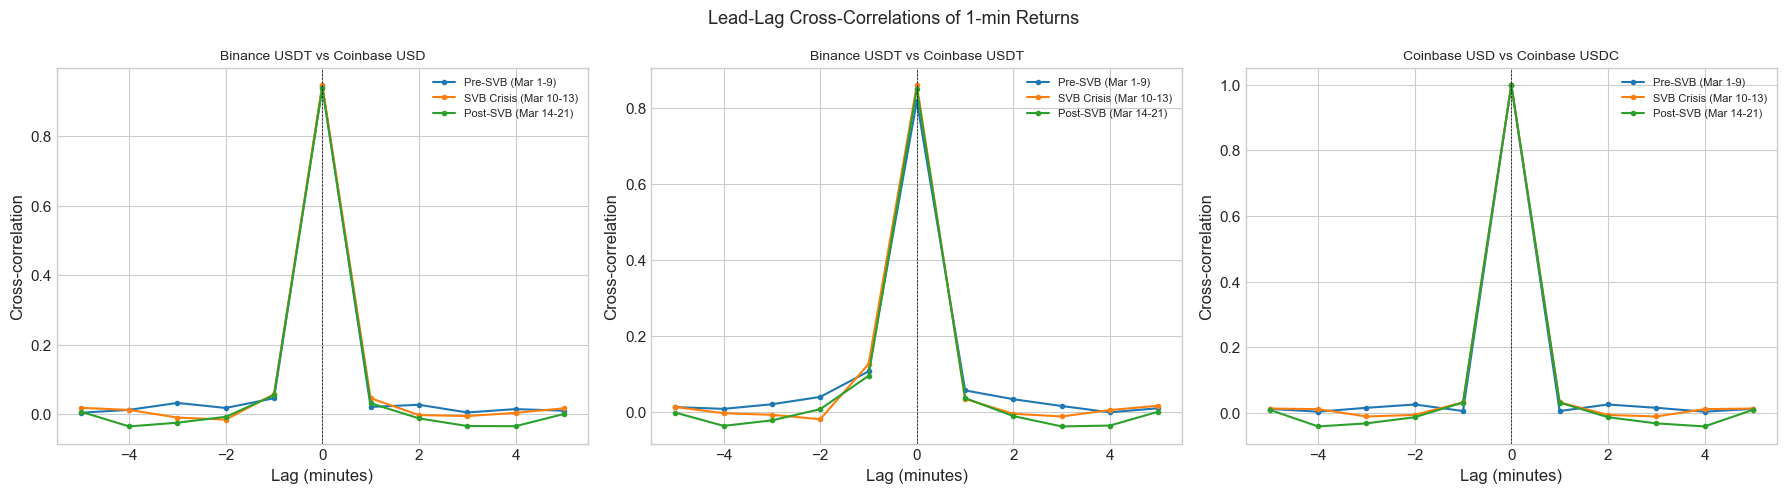

In [79]:
# ============================================================
# Cell 22: Lead-lag analysis using cross-correlation
# ============================================================

def cross_corr(x: pd.Series, y: pd.Series, max_lag: int = 10) -> pd.Series:
    """
    Compute cross-correlation at different lags (in minutes).
    Positive lag => x leads y. Negative lag => y leads x.
    """
    results = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            x_shift = x.shift(lag)
            pair = pd.concat([x_shift, y], axis=1).dropna()
        else:
            y_shift = y.shift(-lag)
            pair = pd.concat([x, y_shift], axis=1).dropna()

        if len(pair) < 2 or pair.iloc[:, 0].nunique() < 2 or pair.iloc[:, 1].nunique() < 2:
            results[lag] = np.nan
        else:
            results[lag] = pair.iloc[:, 0].corr(pair.iloc[:, 1])

    return pd.Series(results)

# Lead-lag: Binance BTC/USDT vs Coinbase BTC/USD
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs_to_compare = [
    ('binance_btcusdt', 'coinbase_btcusd', 'Binance USDT vs Coinbase USD'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance USDT vs Coinbase USDT'),
    ('coinbase_btcusd', 'coinbase_btcusdc', 'Coinbase USD vs Coinbase USDC'),
]

for idx, (col1, col2, title) in enumerate(pairs_to_compare):
    ax = axes[idx]
    for regime_name, (t0, t1) in regimes.items():
        rmask = (returns.index >= t0) & (returns.index < t1)
        cc = cross_corr(returns.loc[rmask, col1], returns.loc[rmask, col2], max_lag=5)
        ax.plot(cc.index, cc.values, marker='o', markersize=3, label=regime_name)
    ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Lag (minutes)')
    ax.set_ylabel('Cross-correlation')
    ax.legend(fontsize=8)

plt.suptitle('Lead-Lag Cross-Correlations of 1-min Returns', fontsize=13)
plt.tight_layout()
plt.savefig('fig_lead_lag.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 8. Intraday Patterns & Time-of-Day Effects

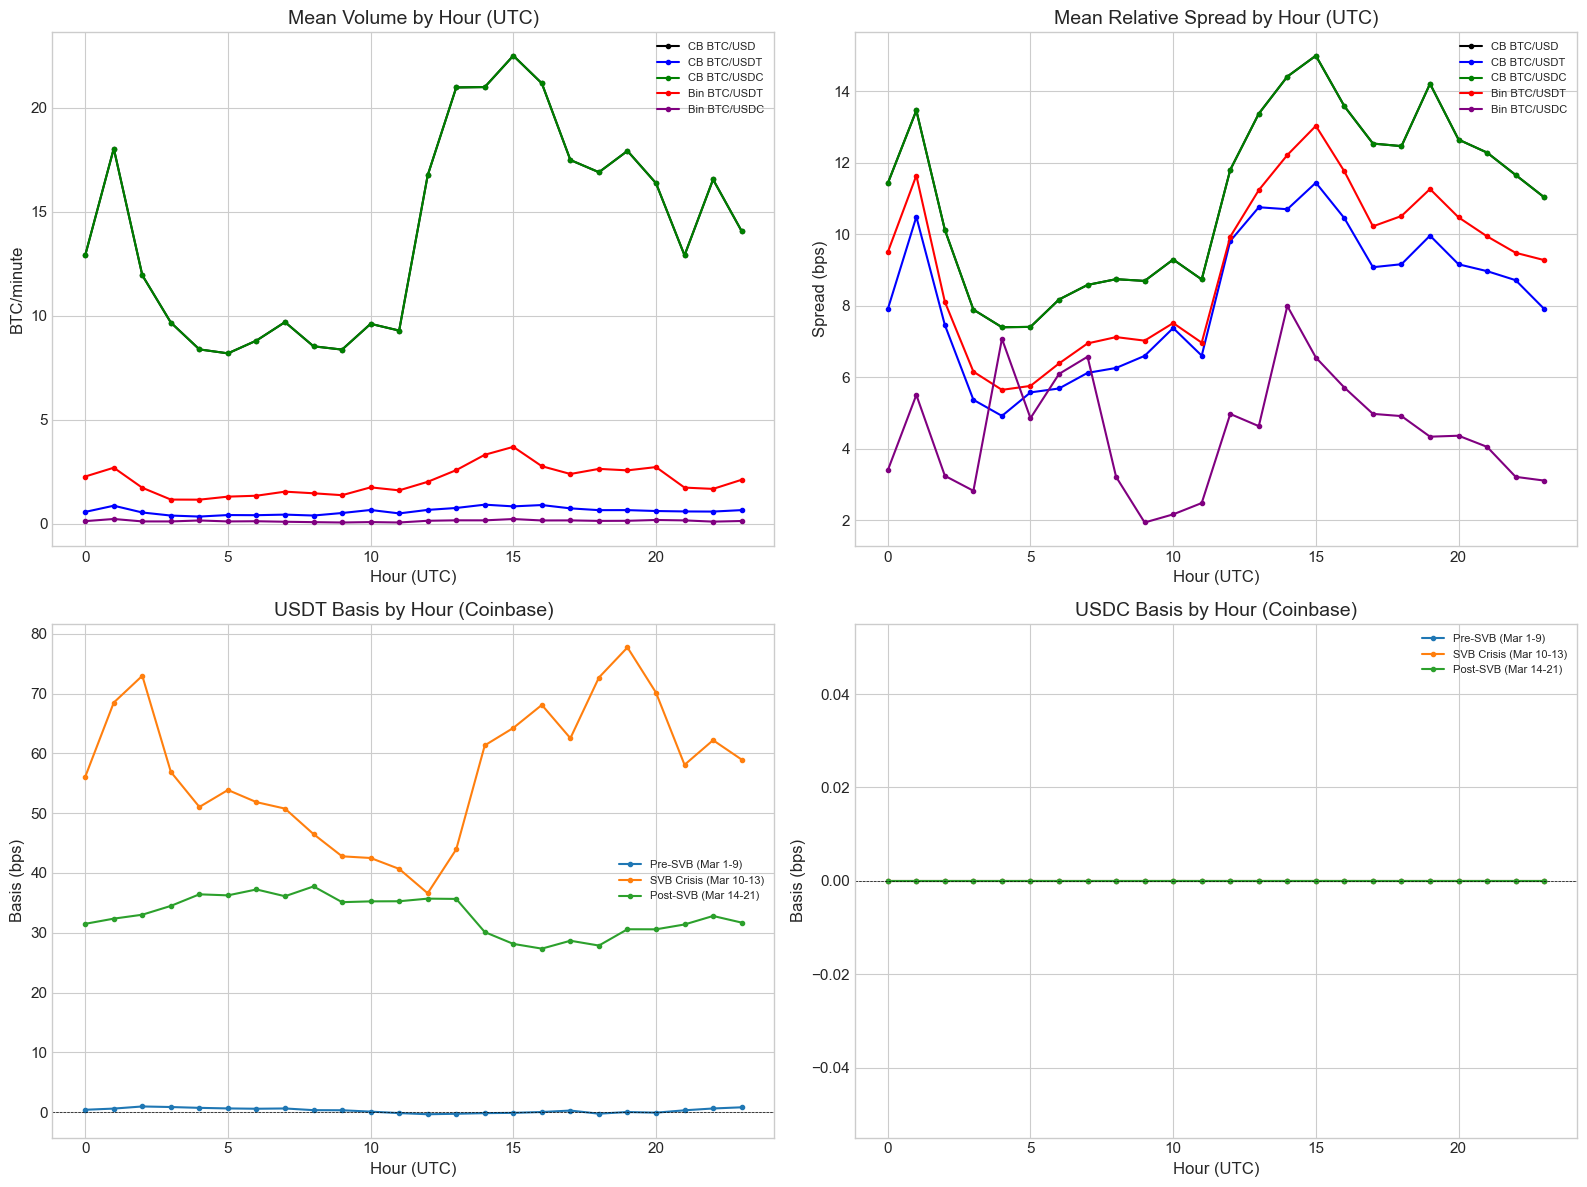

In [80]:
# ============================================================
# Cell 23: Intraday patterns — volume, spread, and basis by hour of day
# ============================================================

# Add hour column
hour = volumes.index.hour

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Volume by hour
ax = axes[0, 0]
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'CB BTC/USDC', 'green'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hourly_mean = volumes[col].groupby(hour).mean()
    ax.plot(hourly_mean.index, hourly_mean.values, marker='o', markersize=3, label=label, color=color)
ax.set_title('Mean Volume by Hour (UTC)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('BTC/minute')
ax.legend(fontsize=8)

# Spread by hour
ax = axes[0, 1]
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'CB BTC/USDC', 'green'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hourly_mean = rel_spreads[col].groupby(hour).mean()
    ax.plot(hourly_mean.index, hourly_mean.values, marker='o', markersize=3, label=label, color=color)
ax.set_title('Mean Relative Spread by Hour (UTC)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Spread (bps)')
ax.legend(fontsize=8)

# USDT basis by hour
ax = axes[1, 0]
for regime_name, (t0, t1) in regimes.items():
    rmask = (basis_usdt_coinbase.index >= t0) & (basis_usdt_coinbase.index < t1)
    hourly_basis = basis_usdt_coinbase[rmask].groupby(basis_usdt_coinbase[rmask].index.hour).mean()
    ax.plot(hourly_basis.index, hourly_basis.values, marker='o', markersize=3, label=regime_name)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('USDT Basis by Hour (Coinbase)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)

# USDC basis by hour
ax = axes[1, 1]
for regime_name, (t0, t1) in regimes.items():
    rmask = (basis_usdc_coinbase.index >= t0) & (basis_usdc_coinbase.index < t1)
    hourly_basis = basis_usdc_coinbase[rmask].groupby(basis_usdc_coinbase[rmask].index.hour).mean()
    ax.plot(hourly_basis.index, hourly_basis.values, marker='o', markersize=3, label=regime_name)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('USDC Basis by Hour (Coinbase)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('fig_intraday_patterns.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 9. Basis Mean-Reversion & Half-Life Analysis

We test whether the cross-currency basis is mean-reverting using an Ornstein-Uhlenbeck (OU) framework. The half-life of mean-reversion tells us how quickly deviations from parity decay.

In [81]:
# ============================================================
# Cell 24: OU mean-reversion estimation
# ============================================================
from scipy import stats as sp_stats

def estimate_ou_halflife(series: pd.Series) -> dict:
    """
    Estimate the half-life of mean reversion via OLS on:
        delta_x(t) = alpha + beta * x(t-1) + epsilon
    Half-life = -ln(2) / beta
    """
    s = series.dropna()
    if len(s) < 100 or s.nunique() < 2:
        return {'half_life_min': np.nan, 'beta': np.nan, 'p_value': np.nan, 'n': len(s)}

    y = s.diff().iloc[1:].values
    x = s.iloc[:-1].values

    # Guard against constant x or y (linregress fails)
    if np.allclose(x, x[0]) or np.allclose(y, y[0]):
        return {'half_life_min': np.nan, 'beta': np.nan, 'p_value': np.nan, 'n': len(y)}

    # OLS regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)

    if slope >= 0:
        half_life = np.inf
    else:
        half_life = -np.log(2) / slope

    return {
        'half_life_min': half_life,
        'half_life_hours': half_life / 60 if np.isfinite(half_life) else np.inf,
        'beta': slope,
        'p_value': p_value,
        'mean_level': intercept / (-slope) if slope != 0 else np.nan,
        'n': len(y)
    }

print("Half-Life of Mean Reversion (Ornstein-Uhlenbeck)")
print("=" * 80)

hl_results = []
for basis_name, bs in basis_series.items():
    for regime_name, (t0, t1) in regimes.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)]
        result = estimate_ou_halflife(subset)
        result['Basis'] = basis_name
        result['Regime'] = regime_name
        hl_results.append(result)
    # Full period
    result = estimate_ou_halflife(bs)
    result['Basis'] = basis_name
    result['Regime'] = 'Full Period'
    hl_results.append(result)

hl_df = pd.DataFrame(hl_results)
hl_df = hl_df[['Basis', 'Regime', 'half_life_min', 'half_life_hours', 'beta', 'p_value', 'n']]
hl_df.set_index(['Basis', 'Regime'], inplace=True)
hl_df.round(4)


Half-Life of Mean Reversion (Ornstein-Uhlenbeck)


half_life_min  \
Basis                      Regime                                  
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)              1.1950   
                           SVB Crisis (Mar 10-13)        71.1407   
                           Post-SVB (Mar 14-21)           4.2503   
                           Full Period                   51.4694   
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)                 NaN   
                           SVB Crisis (Mar 10-13)            NaN   
                           Post-SVB (Mar 14-21)              NaN   
                           Full Period                       NaN   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)              1.4346   
                           SVB Crisis (Mar 10-13)       451.3278   
                           Post-SVB (Mar 14-21)           3.3724   
                           Full Period                  473.5348   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)              1.1950   
                           SVB Crisis (Mar 10-13)        71.1407   
                           Post-SVB (Mar 14-21)           4.2503   
                           Full Period                   51.4694   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)              0.9537   
                           SVB Crisis (Mar 10-13)         1.0804   
                           Post-SVB (Mar 14-21)           0.8494   
                           Full Period                    0.9279   

                                                   half_life_hours    beta  \
Basis                      Regime                                            
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)                0.0199 -0.5800   
                           SVB Crisis (Mar 10-13)           1.1857 -0.0097   
                           Post-SVB (Mar 14-21)             0.0708 -0.1631   
                           Full Period                      0.8578 -0.0135   
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)                   NaN     NaN   
                           SVB Crisis (Mar 10-13)              NaN     NaN   
                           Post-SVB (Mar 14-21)                NaN     NaN   
                           Full Period                         NaN     NaN   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)                0.0239 -0.4832   
                           SVB Crisis (Mar 10-13)           7.5221 -0.0015   
                           Post-SVB (Mar 14-21)             0.0562 -0.2055   
                           Full Period                      7.8922 -0.0015   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)                0.0199 -0.5800   
                           SVB Crisis (Mar 10-13)           1.1857 -0.0097   
                           Post-SVB (Mar 14-21)             0.0708 -0.1631   
                           Full Period                      0.8578 -0.0135   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)                0.0159 -0.7268   
                           SVB Crisis (Mar 10-13)           0.0180 -0.6415   
                           Post-SVB (Mar 14-21)             0.0142 -0.8160   
                           Full Period                      0.0155 -0.7470   

                                                   p_value      n  
Basis                      Regime                                  
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)        0.0000  12639  
                           SVB Crisis (Mar 10-13)   0.0000   5755  
                           Post-SVB (Mar 14-21)     0.0000  11518  
                           Full Period              0.0000  29914  
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)           NaN  12688  
                           SVB Crisis (Mar 10-13)      NaN   5760  
                           Post-SVB (Mar 14-21)        NaN  11520  
                           Full Period                 NaN  29968  
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)        0.0000  12959  
                           SVB Crisis (Mar 10-13)   0.0342   5759  
                     

---
## 10. Granger Causality & Information Flow

In [82]:
# ============================================================
# Cell 25: Granger causality tests
# ============================================================
from statsmodels.tsa.stattools import grangercausalitytests

def run_granger(x: pd.Series, y: pd.Series, maxlag: int = 5) -> dict:
    """
    Test if x Granger-causes y.
    Returns dict of {lag: p_value} for F-test.
    """
    common = x.dropna().index.intersection(y.dropna().index)
    data = pd.DataFrame({'y': y.loc[common], 'x': x.loc[common]}).dropna()
    if len(data) < 100:
        return {}
    try:
        result = grangercausalitytests(data[['y', 'x']], maxlag=maxlag, verbose=False)
        return {lag: result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1)}
    except Exception:
        return {}

# Test: Does Binance BTC/USDT Granger-cause Coinbase BTC/USD?
granger_pairs = [
    ('binance_btcusdt', 'coinbase_btcusd', 'Binance USDT → Coinbase USD'),
    ('coinbase_btcusd', 'binance_btcusdt', 'Coinbase USD → Binance USDT'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance USDT → Coinbase USDT'),
    ('coinbase_btcusdt', 'binance_btcusdt', 'Coinbase USDT → Binance USDT'),
]

print("Granger Causality p-values (lower = stronger evidence of causation)")
print("=" * 80)

granger_results = []
for col1, col2, label in granger_pairs:
    for regime_name, (t0, t1) in regimes.items():
        rmask = (returns.index >= t0) & (returns.index < t1)
        pvals = run_granger(returns.loc[rmask, col1], returns.loc[rmask, col2], maxlag=5)
        for lag, pv in pvals.items():
            granger_results.append({
                'Direction': label,
                'Regime': regime_name,
                'Lag (min)': lag,
                'p-value': pv,
                'Significant (5%)': '***' if pv < 0.01 else ('**' if pv < 0.05 else ('*' if pv < 0.1 else ''))
            })

granger_df = pd.DataFrame(granger_results)
# Show lag=1 results as summary
summary = granger_df[granger_df['Lag (min)'] == 1].pivot_table(
    index='Direction', columns='Regime', values='p-value'
)
print("\nGranger Causality p-values at lag=1 minute:")
summary.round(6)

Granger Causality p-values (lower = stronger evidence of causation)

Granger Causality p-values at lag=1 minute:


Regime,Post-SVB (Mar 14-21),Pre-SVB (Mar 1-9),SVB Crisis (Mar 10-13)
Direction,,,
Binance USDT → Coinbase USD,0.691398,0.0,0.000369
Binance USDT → Coinbase USDT,0.000000,0.0,0.000000
Coinbase USD → Binance USDT,0.000000,0.0,0.000005
Coinbase USDT → Binance USDT,0.000000,0.0,0.000000


---
## 11. Rolling Basis Volatility & Regime Detection

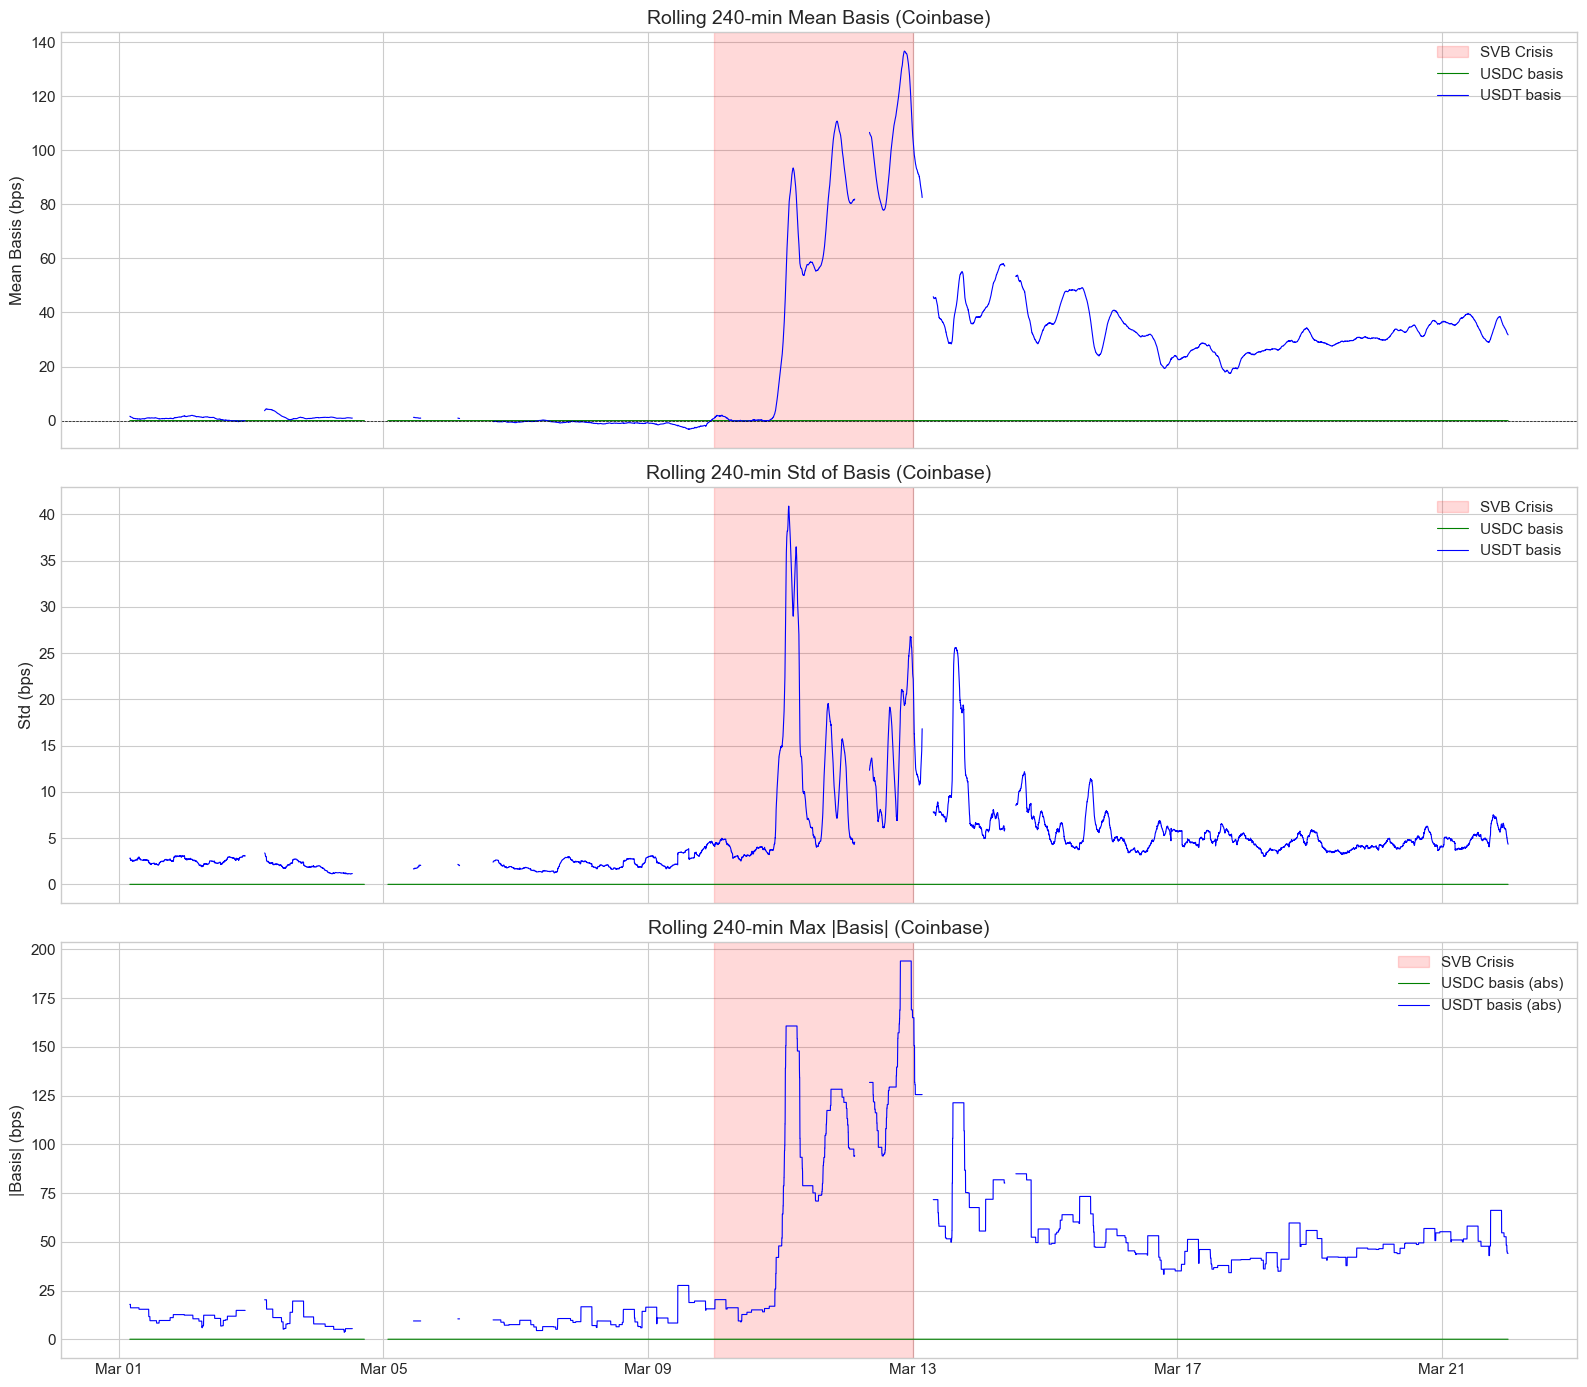

In [83]:
# ============================================================
# Cell 26: Rolling basis statistics
# ============================================================

# Rolling 4-hour (240-min) statistics of the USDC basis
window = 240

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

# Rolling mean basis
ax = axes[0]
ax.plot(basis_usdc_coinbase.rolling(window).mean(), linewidth=0.8, color='green', label='USDC basis')
ax.plot(basis_usdt_coinbase.rolling(window).mean(), linewidth=0.8, color='blue', label='USDT basis')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title(f'Rolling {window}-min Mean Basis (Coinbase)')
ax.set_ylabel('Mean Basis (bps)')
ax.legend()

# Rolling std of basis
ax = axes[1]
ax.plot(basis_usdc_coinbase.rolling(window).std(), linewidth=0.8, color='green', label='USDC basis')
ax.plot(basis_usdt_coinbase.rolling(window).std(), linewidth=0.8, color='blue', label='USDT basis')
ax.set_title(f'Rolling {window}-min Std of Basis (Coinbase)')
ax.set_ylabel('Std (bps)')
ax.legend()

# Rolling abs max basis
ax = axes[2]
ax.plot(basis_usdc_coinbase.abs().rolling(window).max(), linewidth=0.8, color='green', label='USDC basis (abs)')
ax.plot(basis_usdt_coinbase.abs().rolling(window).max(), linewidth=0.8, color='blue', label='USDT basis (abs)')
ax.set_title(f'Rolling {window}-min Max |Basis| (Coinbase)')
ax.set_ylabel('|Basis| (bps)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_rolling_basis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 12. Cointegration & Error Correction Analysis

In [84]:
# ============================================================
# Cell 27: Engle-Granger cointegration test
# ============================================================
from statsmodels.tsa.stattools import coint, adfuller

print("Cointegration Tests (Engle-Granger)")
print("=" * 80)
print("H0: No cointegration (series are not cointegrated)")
print()

coint_pairs = [
    ('coinbase_btcusd', 'coinbase_btcusdt', 'Coinbase USD vs USDT'),
    ('coinbase_btcusd', 'coinbase_btcusdc', 'Coinbase USD vs USDC'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance vs Coinbase USDT'),
    ('binance_btcusdt', 'binance_btcusdc', 'Binance USDT vs USDC'),
]

coint_results = []
for col1, col2, label in coint_pairs:
    for regime_name, (t0, t1) in regimes.items():
        rmask = (closes.index >= t0) & (closes.index < t1)
        s1 = closes.loc[rmask, col1].dropna()
        s2 = closes.loc[rmask, col2].dropna()
        common = s1.index.intersection(s2.index)
        if len(common) < 100:
            continue
        try:
            stat, pval, crit = coint(s1.loc[common], s2.loc[common])
            coint_results.append({
                'Pair': label,
                'Regime': regime_name,
                'Test Stat': stat,
                'p-value': pval,
                '1% Critical': crit[0],
                '5% Critical': crit[1],
                'Cointegrated (5%)': 'Yes' if pval < 0.05 else 'No'
            })
        except Exception as e:
            print(f"  Error on {label} / {regime_name}: {e}")

coint_df = pd.DataFrame(coint_results)
coint_df.set_index(['Pair', 'Regime'], inplace=True)
coint_df.round(4)

Cointegration Tests (Engle-Granger)
H0: No cointegration (series are not cointegrated)



/var/folders/3s/gp2ztt_d2cn_dn33vj1cbx2h0000gn/T/ipykernel_86594/3823963789.py:28: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  stat, pval, crit = coint(s1.loc[common], s2.loc[common])
/var/folders/3s/gp2ztt_d2cn_dn33vj1cbx2h0000gn/T/ipykernel_86594/3823963789.py:28: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  stat, pval, crit = coint(s1.loc[common], s2.loc[common])
/var/folders/3s/gp2ztt_d2cn_dn33vj1cbx2h0000gn/T/ipykernel_86594/3823963789.py:28: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  stat, pval, crit = coint(s1.loc[common], s2.loc[common])


Test Stat  p-value  \
Pair                     Regime                                       
Coinbase USD vs USDT     Pre-SVB (Mar 1-9)         -9.1956   0.0000   
                         SVB Crisis (Mar 10-13)    -2.2643   0.3915   
                         Post-SVB (Mar 14-21)      -4.0355   0.0064   
Coinbase USD vs USDC     Pre-SVB (Mar 1-9)            -inf   0.0000   
                         SVB Crisis (Mar 10-13)       -inf   0.0000   
                         Post-SVB (Mar 14-21)         -inf   0.0000   
Binance vs Coinbase USDT Pre-SVB (Mar 1-9)        -23.4194   0.0000   
                         SVB Crisis (Mar 10-13)    -9.2697   0.0000   
                         Post-SVB (Mar 14-21)     -11.0139   0.0000   
Binance USDT vs USDC     Pre-SVB (Mar 1-9)        -11.7158   0.0000   
                         SVB Crisis (Mar 10-13)    -1.9064   0.5768   
                         Post-SVB (Mar 14-21)      -4.6637   0.0007   

                                                 1% Critical  5% Critical  \
Pair                     Regime                                             
Coinbase USD vs USDT     Pre-SVB (Mar 1-9)           -3.8973      -3.3366   
                         SVB Crisis (Mar 10-13)      -3.8983      -3.3372   
                         Post-SVB (Mar 14-21)        -3.8974      -3.3367   
Coinbase USD vs USDC     Pre-SVB (Mar 1-9)           -3.8973      -3.3366   
                         SVB Crisis (Mar 10-13)      -3.8983      -3.3372   
                         Post-SVB (Mar 14-21)        -3.8974      -3.3367   
Binance vs Coinbase USDT Pre-SVB (Mar 1-9)           -3.8973      -3.3366   
                         SVB Crisis (Mar 10-13)      -3.8983      -3.3372   
                         Post-SVB (Mar 14-21)        -3.8974      -3.3367   
Binance USDT vs USDC     Pre-SVB (Mar 1-9)           -3.8973      -3.3366   
                         SVB Crisis (Mar 10-13)      -3.8983      -3.3372   
                         Post-SVB (Mar 14-21)        -3.8974      -3.3367   

                                                Cointegrated (5%)  
Pair                     Regime                                    
Coinbase USD vs USDT     Pre-SVB (Mar 1-9)                    Yes  
                         SVB Crisis (Mar 10-13)                No  
                         Post-SVB (Mar 14-21)                 Yes  
Coinbase USD vs USDC     Pre-SVB (Mar 1-9)                    Yes  
                         SVB Crisis (Mar 10-13)               Yes  
                         Post-SVB (Mar 14-21)                 Yes  
Binance vs Coinbase USDT Pre-SVB (Mar 1-9)                    Yes  
                         SVB Crisis (Mar 10-13)               Yes  
                         Post-SVB (Mar 14-21)                 Yes  
Binance USDT vs USDC     Pre-SVB (Mar 1-9)                    Yes  
                         SVB Crisis (Mar 10-13)                No  
                         Post-SVB (Mar 14-21)                 Yes

In [85]:
# ============================================================
# Cell 28: ADF test on basis series (stationarity)
# ============================================================

print("Augmented Dickey-Fuller Tests on Basis Series")
print("H0: Unit root (non-stationary)")
print("=" * 80)

adf_results = []
for basis_name, bs in basis_series.items():
    for regime_name, (t0, t1) in regimes.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)].dropna()
        if len(subset) < 100:
            continue
        try:
            stat, pval, usedlag, nobs, crit, icbest = adfuller(subset, maxlag=20, autolag='AIC')
            adf_results.append({
                'Basis': basis_name,
                'Regime': regime_name,
                'ADF Stat': stat,
                'p-value': pval,
                'Lags Used': usedlag,
                'Stationary (5%)': 'Yes' if pval < 0.05 else 'No'
            })
        except Exception:
            pass

adf_df = pd.DataFrame(adf_results)
adf_df.set_index(['Basis', 'Regime'], inplace=True)
adf_df.round(4)

Augmented Dickey-Fuller Tests on Basis Series
H0: Unit root (non-stationary)


ADF Stat  p-value  \
Basis                      Regime                                      
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)       -13.5362   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0050   0.2844   
                           Post-SVB (Mar 14-21)     -4.0178   0.0013   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)       -16.9376   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0769   0.2539   
                           Post-SVB (Mar 14-21)     -6.7859   0.0000   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)       -13.5362   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0050   0.2844   
                           Post-SVB (Mar 14-21)     -4.0178   0.0013   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)       -22.9203   0.0000   
                           SVB Crisis (Mar 10-13)   -9.1300   0.0000   
                           Post-SVB (Mar 14-21)    -16.2386   0.0000   

                                                   Lags Used Stationary (5%)  
Basis                      Regime                                             
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)          9              No  
                           Post-SVB (Mar 14-21)           20             Yes  
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)         20              No  
                           Post-SVB (Mar 14-21)           20             Yes  
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)          9              No  
                           Post-SVB (Mar 14-21)           20             Yes  
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)              16             Yes  
                           SVB Crisis (Mar 10-13)         19             Yes  
                           Post-SVB (Mar 14-21)           20             Yes

---
## 13. Comprehensive Summary Dashboard

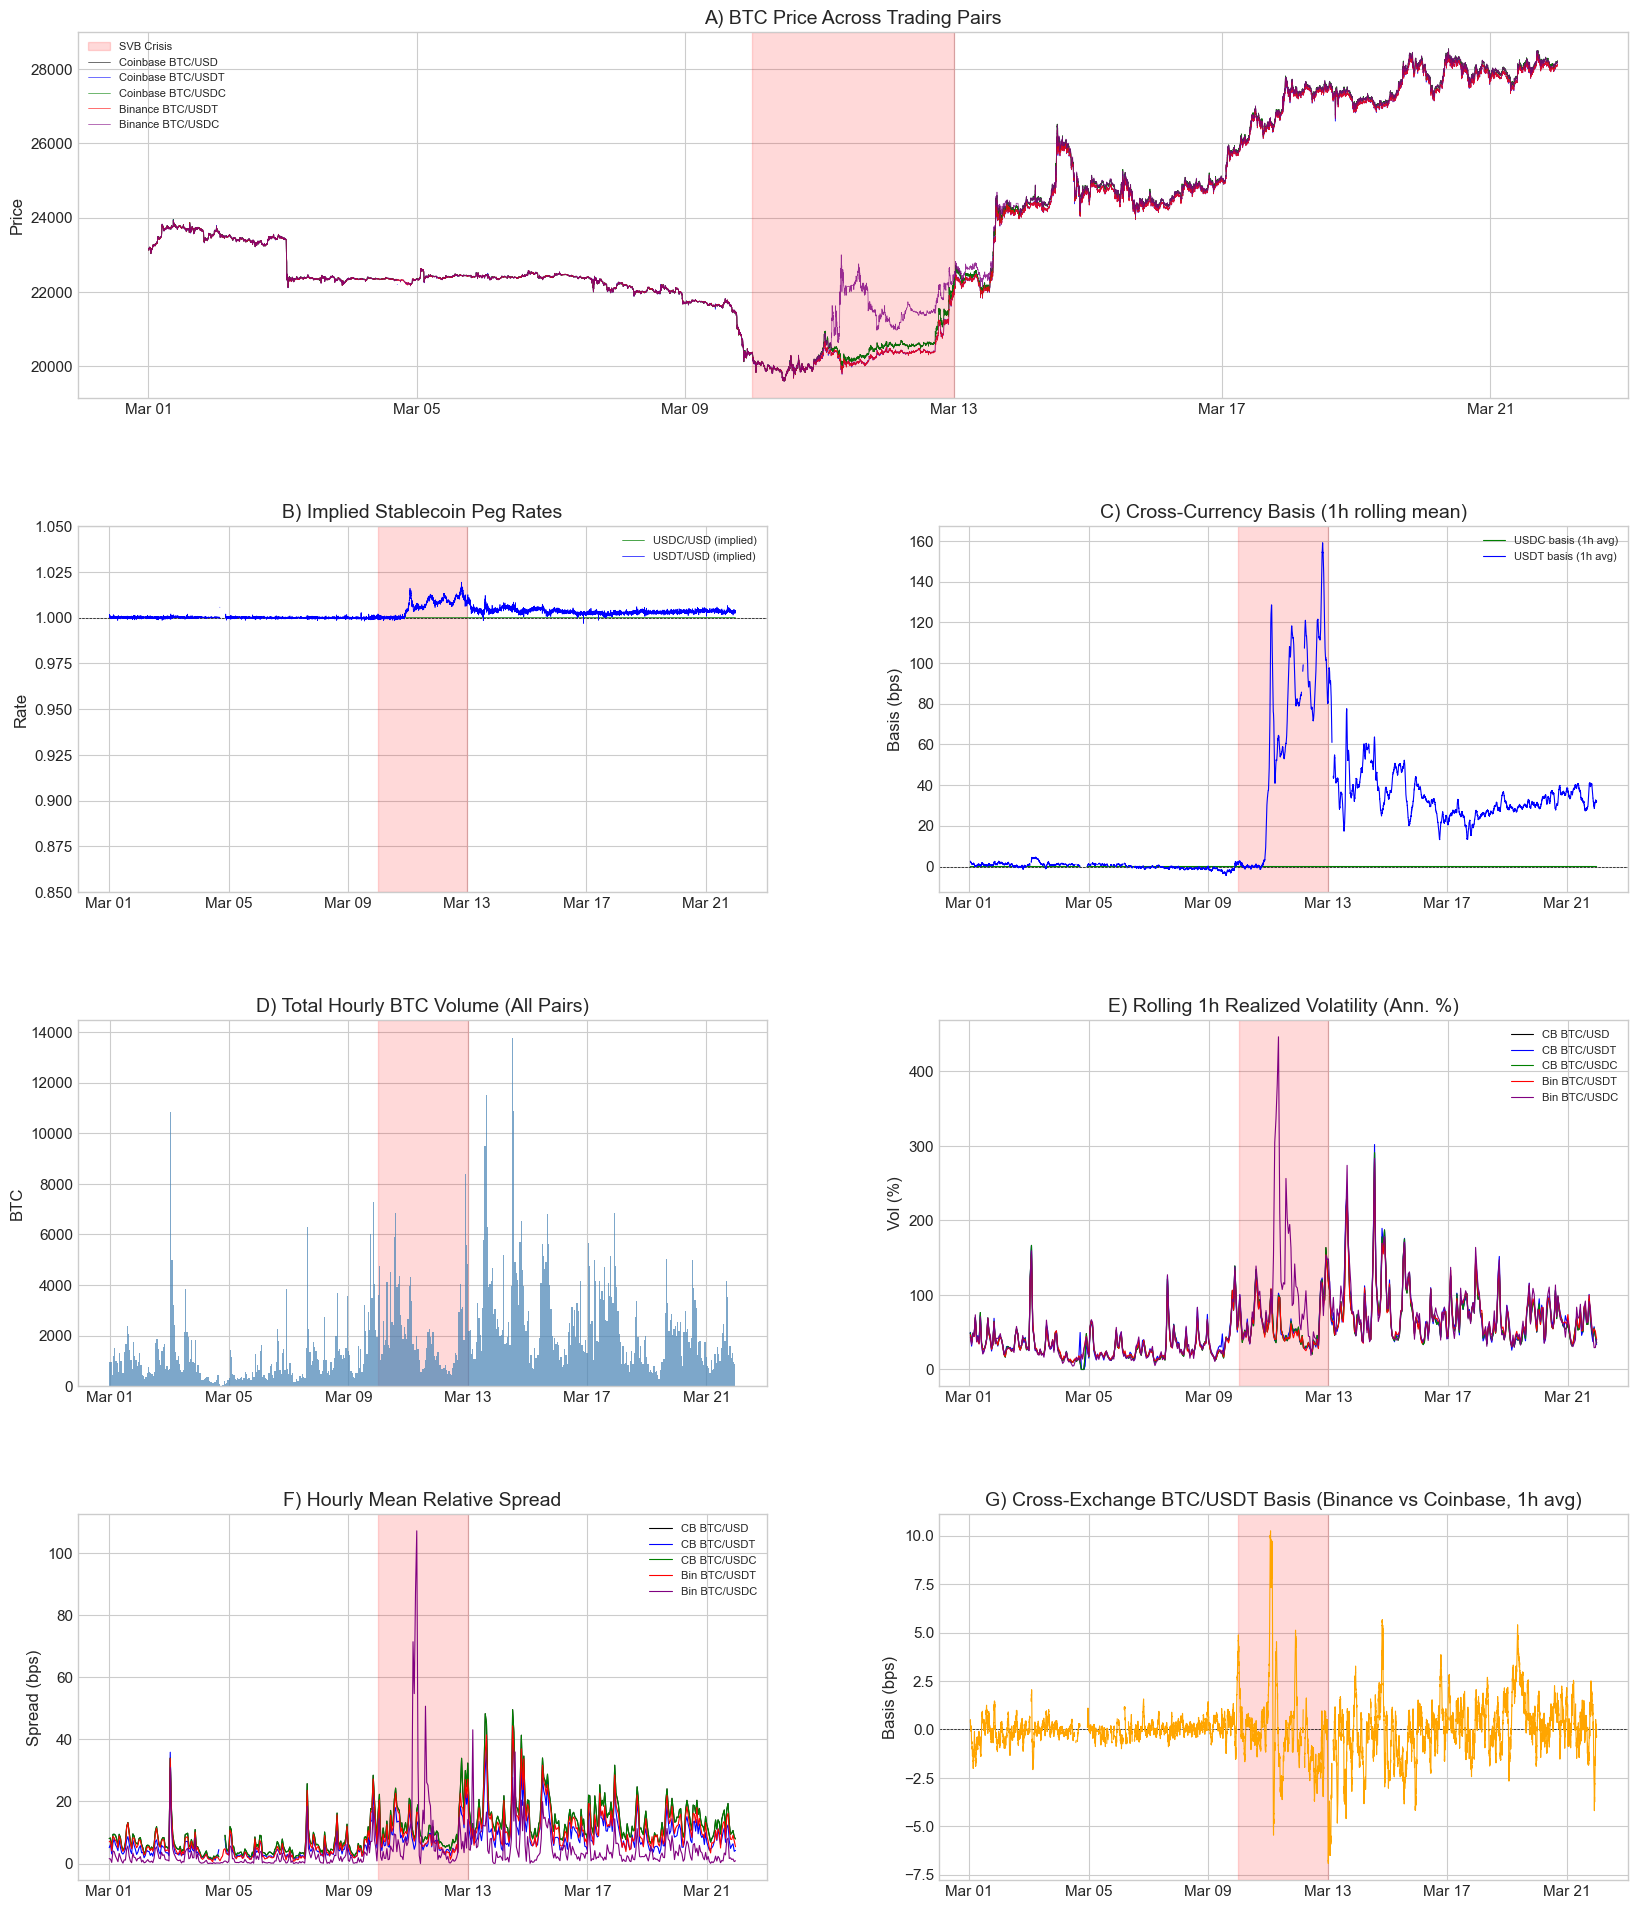

Summary dashboard saved: fig_summary_dashboard.png


In [86]:
# ============================================================
# Cell 29: Summary dashboard figure
# ============================================================

fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

# Panel 1: BTC price across all pairs
ax = fig.add_subplot(gs[0, :])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
for col, label, color in [
    ('coinbase_btcusd', 'Coinbase BTC/USD', 'black'),
    ('coinbase_btcusdt', 'Coinbase BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'Coinbase BTC/USDC', 'green'),
    ('binance_btcusdt', 'Binance BTC/USDT', 'red'),
    ('binance_btcusdc', 'Binance BTC/USDC', 'purple'),
]:
    ax.plot(closes[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('A) BTC Price Across Trading Pairs')
ax.set_ylabel('Price')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 2: USDC peg
ax = fig.add_subplot(gs[1, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes['implied_usdc_usd_coinbase'], linewidth=0.5, color='green', label='USDC/USD (implied)')
ax.plot(closes['implied_usdt_usd_coinbase'], linewidth=0.5, color='blue', label='USDT/USD (implied)')
ax.set_title('B) Implied Stablecoin Peg Rates')
ax.set_ylabel('Rate')
ax.set_ylim(0.85, 1.05)
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 3: Cross-currency basis
ax = fig.add_subplot(gs[1, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_usdc_coinbase.rolling(60).mean(), linewidth=0.8, color='green', label='USDC basis (1h avg)')
ax.plot(basis_usdt_coinbase.rolling(60).mean(), linewidth=0.8, color='blue', label='USDT basis (1h avg)')
ax.set_title('C) Cross-Currency Basis (1h rolling mean)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 4: Volume
ax = fig.add_subplot(gs[2, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
hourly_vol_total = volumes[btc_cols].sum(axis=1).resample('1h').sum()
ax.bar(hourly_vol_total.index, hourly_vol_total.values, width=1/24, color='steelblue', alpha=0.7)
ax.set_title('D) Total Hourly BTC Volume (All Pairs)')
ax.set_ylabel('BTC')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 5: Realized vol
ax = fig.add_subplot(gs[2, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'CB BTC/USDC', 'green'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    rv = rolling_vol[col].resample('1h').mean()
    ax.plot(rv, linewidth=0.8, label=label, color=color)
ax.set_title('E) Rolling 1h Realized Volatility (Ann. %)')
ax.set_ylabel('Vol (%)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 6: Spread
ax = fig.add_subplot(gs[3, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('coinbase_btcusdc', 'CB BTC/USDC', 'green'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hs = rel_spreads[col].resample('1h').mean()
    ax.plot(hs, linewidth=0.8, label=label, color=color)
ax.set_title('F) Hourly Mean Relative Spread')
ax.set_ylabel('Spread (bps)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 7: Cross-exchange basis
ax = fig.add_subplot(gs[3, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_cross_exchange.rolling(60).mean(), linewidth=0.8, color='orange')
ax.set_title('G) Cross-Exchange BTC/USDT Basis (Binance vs Coinbase, 1h avg)')
ax.set_ylabel('Basis (bps)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.savefig('fig_summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("Summary dashboard saved: fig_summary_dashboard.png")


---
## 14. Regulatory Overlay: Key Findings & Policy Implications

### Empirical Findings

1. **USDC De-Peg Event (March 10-13, 2023):**
   - USDC traded at a significant discount to USD, with the implied USDC/USD rate falling well below $1
   - BTC/USDC prices diverged sharply from BTC/USD, creating massive cross-currency basis
   - USDT, by contrast, traded at a *premium* to USD during the crisis — a flight to the "safer" stablecoin

2. **Cross-Currency Basis:**
   - Under normal conditions (pre-crisis), basis spreads are small but nonzero, typically a few bps
   - During the SVB crisis, the USDC basis exploded to hundreds of bps
   - Mean-reversion half-life varies by regime: faster in normal times, slower during stress

3. **Liquidity Fragmentation:**
   - USDT pairs dominate volume on Binance; USD pairs dominate on Coinbase
   - During the crisis, volume surged across all pairs, but USDC pair volume was particularly elevated as traders fled the de-pegged stablecoin
   - Spreads widened significantly during the crisis, especially for USDC-quoted pairs

4. **Cross-Exchange Dynamics:**
   - Binance leads price discovery for USDT pairs (higher volume, tighter spreads)
   - Cross-exchange basis is normally small but can widen during stress
   - Granger causality tests reveal information flow patterns between exchanges

### Implications of the GENIUS Act & Stablecoin Regulation

1. **Reserve Transparency:** Mandatory reserve backing and reporting would reduce the counterparty risk that caused the USDC de-peg. Had Circle's SVB exposure been subject to real-time disclosure, the market shock would likely have been less severe.

2. **Cross-Currency Basis Compression:** Regulated stablecoins with guaranteed 1:1 redemption would compress cross-currency basis spreads, as the risk of stablecoin-specific shocks diminishes.

3. **Liquidity Concentration:** Regulation may favor compliant stablecoins (USDC over USDT if Tether remains offshore), potentially shifting liquidity toward USD and USDC pairs on US-regulated exchanges.

4. **Settlement Integration:** Visa's USDC settlement offerings and broader payment network adoption could reduce the fragmentation between fiat and stablecoin liquidity pools, improving arbitrage efficiency.

5. **Systemic Risk:** The SVB episode demonstrates that stablecoin reserve risk can propagate rapidly through crypto markets. The GENIUS Act's reserve and oversight requirements aim to prevent such contagion.

In [87]:
# ============================================================
# Cell 30: Final data export for reproducibility
# ============================================================

# Save key derived datasets
closes.to_parquet(os.path.join(DATA_DIR, 'closes_panel.parquet'))
volumes.to_parquet(os.path.join(DATA_DIR, 'volumes_panel.parquet'))
spreads.to_parquet(os.path.join(DATA_DIR, 'spreads_panel.parquet'))
returns.to_parquet(os.path.join(DATA_DIR, 'returns_panel.parquet'))

basis_export = pd.DataFrame({
    'usdt_basis_coinbase': basis_usdt_coinbase,
    'usdc_basis_coinbase': basis_usdc_coinbase,
    'usdt_usdc_basis_binance': basis_usdt_usdc_binance,
    'usdt_usdc_basis_coinbase': basis_usdt_usdc_coinbase,
    'cross_exchange_btcusdt': basis_cross_exchange,
})
basis_export.to_parquet(os.path.join(DATA_DIR, 'basis_panel.parquet'))

print("All derived data exported to ./data/")
print("
Files:")
for f in sorted(os.listdir(DATA_DIR)):
    size = os.path.getsize(os.path.join(DATA_DIR, f))
    print(f"  {f:40s}  {size/1024:.0f} KB")

print("
" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)


SyntaxError: unterminated string literal (detected at line 21) (3026055777.py, line 21)